In [ ]:
#to do:
#write conclusion with final results

#write up:
#lightgbm and rf able to get over 99% accuracy on train
    #issue was generalization
    #mean encoding was strong: maybe I needed to regularize it more?
    #considered more models and features but issue not with models but regularizing well

#DONE finish hyper param tuning on lightGBM and LR
#DONE test new ensemble
#DONE outputs for each model
#maybe better mean encoding
#meh: less features (ie no mean encoding or binning)


In [2]:
#to do/notes:
#DONE look at results of EDA
#DONE add in features
    #DONE feature transforms for one hot
    #DONE scaling
    #DONE robust scaler
    #DONE frequency encoder
    #DONE mean encodings need a join/lookup for the test features based on id and target type
#set up pipeline
    #DONE print out train and test accuracy
    #DONE check algorithms for which label type
    #set up CV
        #using CV with tree model but not actuallly doing anything I don't think
    #how to hyperparam tune all that nonsense
    #better way to feature select
    #maybe make a not how lightgbm was able to get super high accuracy, became a regularization problem
    #find out which features overfitting
    #CHANGE FROM ACCURACY TO A DIFFERENT METRIC? NOT PICKING UP ON RARER CASES
    #thinking i'm going to skip AUC curve, seems like a lot of work for a minor thing
    
    
#DONE attack_cat: only want certain ones out of them so break it out
#thinking adaboost, lightgbm, naive bayes, knn, logistic LR, random forest, NN
    #then stack it in some way
    #figure good hyperparameters to go over for all of these
        #spreadsheet ahs LightGBM/RF/NN ones to go over

#print out train and test accuracy
#consider how you can improve your train accuracy improves test accuracy has the same CV error or something



#frequency encoding
#mean encoding (see course for regularization methods (notes and worksheet)
    #https://towardsdatascience.com/why-you-should-try-mean-encoding-17057262cd0
#do robust scaler this time instead of log for those categories
#target soft labels: can clip 0 and 1 to 0.05 and 0.95
#do k fold CV testing


#to consider
#stacknet
#i might need a different type of label encoding depending on the model (ie now it's ordinal,
    #might need one hot like I do for neural network)
#mean endcoing
    #could do it as is with train/test for service/state/proto and not regularize it
        #thinking for last two rare values, just replace with 4 then do mean encoding
#using random_forset/Lightbgm to come up with features just for the proto part
    #maybe KNN/PCA as well
#binning: eda notes support this
#to consider/longer term if more time
#consider bagging over all models (chagne teh seed for each bag)

#consider interactions of most eimportant features
    #try many then narrow down with RF (picture in checklist)
#consider 1 vs. all classifiers
#output of RF and GBDT as features
#PCA/KNN or some sort of dimensionality reduction to reduce features
#embeddings from categorical data
#bumper features (kind of meh about this)

#test/train distribution kind of wonky a bit, could distirbute it a bit different

### write up notes:



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
pd.options.display.max_columns = None

In [4]:
import eda_utils

In [5]:
df_train = pd.read_csv('UNSW_NB15_training-set.csv')
df_test = pd.read_csv('UNSW_NB15_testing-set.csv')

#UNSW_NB15_testing-set.csv
#UNSW_NB15_training-set.csv

In [6]:
df_train.groupby('attack_cat').count()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
attack_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Analysis,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
Backdoor,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746,1746
DoS,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264,12264
Exploits,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393,33393
Fuzzers,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184,18184
Generic,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000
Normal,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000
Reconnaissance,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491,10491
Shellcode,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133


In [7]:
df_test.groupby('attack_cat').count()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
attack_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Analysis,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677,677
Backdoor,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583
DoS,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089,4089
Exploits,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132,11132
Fuzzers,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062,6062
Generic,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871,18871
Normal,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000,37000
Reconnaissance,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496
Shellcode,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378,378


In [8]:
#Normal, Analysis, Backdoor, DoS, and Exploits.
df_train = df_train[(df_train.attack_cat == 'Analysis') | (df_train.attack_cat == 'Normal') | (df_train.attack_cat == 'Backdoor')
            | (df_train.attack_cat == 'DoS') | (df_train.attack_cat == 'Exploits')]
df_test = df_test[(df_test.attack_cat == 'Analysis') | (df_test.attack_cat == 'Normal') | (df_test.attack_cat == 'Backdoor')
            | (df_test.attack_cat == 'DoS') | (df_test.attack_cat == 'Exploits')]

In [9]:
df_train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0


In [10]:
df_train.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,105403.000000,105403.000000,105403.000000,105403.000000,1.054030e+05,1.054030e+05,1.054030e+05,105403.000000,105403.000000,1.054030e+05,1.054030e+05,105403.000000,105403.000000,105403.000000,105403.000000,1.054030e+05,105403.000000,105403.000000,1.054030e+05,1.054030e+05,105403.000000,105403.000000,105403.000000,105403.000000,105403.00000,105403.000000,105403.000000,1.054030e+05,105403.000000,105403.000000,105403.000000,105403.000000,105403.000000,105403.000000,105403.000000,105403.000000,105403.000000,105403.000000,105403.000000,105403.000000,105403.000000
mean,62578.820366,1.633793,29.551673,29.492339,1.322076e+04,2.400769e+04,5.339870e+04,130.827519,89.307980,5.178371e+07,1.114761e+06,7.387759,11.029828,1558.785751,88.749101,4.421433e+03,850.937298,149.804398,1.247119e+09,1.243985e+09,147.735444,0.044010,0.022223,0.021787,152.47362,194.796230,0.149038,3.294834e+03,4.598844,0.999440,2.873191,1.760073,1.422578,3.788298,0.023586,0.023586,0.188894,3.833525,4.422256,0.026204,0.468706
std,42537.622764,6.948994,174.705524,136.186473,2.239251e+05,1.777918e+05,1.315263e+05,107.426558,109.654528,1.613947e+08,3.042806e+06,84.522433,65.111224,9225.703897,1129.996458,4.014970e+04,4905.273198,125.529976,1.421707e+09,1.417126e+09,125.882987,0.084384,0.046644,0.043570,212.52701,309.063793,0.986560,6.513189e+04,4.908101,1.040274,3.057315,2.191154,1.721223,4.753382,0.157763,0.157763,0.870591,4.521581,4.801826,0.159743,0.499022
min,1.000000,0.000000,1.000000,0.000000,2.800000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,28.00000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,26351.500000,0.000010,2.000000,0.000000,2.000000e+02,0.000000e+00,2.908650e+01,31.000000,0.000000,1.107793e+04,0.000000e+00,0.000000,0.000000,0.009000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,62.00000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,56381.000000,0.046936,10.000000,8.000000,8.280000e+02,3.540000e+02,7.814367e+02,62.000000,29.000000,3.950051e+05,8.387235e+03,2.000000,1.000000,1.799586,0.703726,6.386025e+01,15.650920,255.000000,5.899196e+08,5.954720e+08,255.000000,0.000631,0.000502,0.000123,93.00000,76.000000,0.000000,0.000000e+00,3.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000
75%,95348.500000,0.839224,22.000000,20.000000,2.516000e+03,3.193000e+03,1.062463e+04,254.000000,252.000000,1.632653e+07,5.987987e+05,6.000000,6.000000,65.964383,54.873283,2.964701e+03,140.271836,255.000000,2.452709e+09,2.445421e+09,255.000000,0.073760,0.030087,0.044453,113.00000,146.500000,0.000000,0.000000e+00,6.000000,2.000000,3.000000,2.000000,1.000000,5.000000,0.000000,0.000000,0.000000,4.000000,6.000000,0.000000,1.000000
max,175306.000000,59.999989,9616.000000,10974.000000,1.296523e+07,1.465555e+07,1.000000e+06,255.000000,254.000000,5.344000e+09,2.242273e+07,4803.000000,5484.000000,60009.920000,56716.824000,1.460480e+06,289388.269700,255.000000,4.294959e+09,4.294882e+09,255.000000,2.518893,2.100352,1.520884,1499.00000,1458.000000,172.000000,6.558056e+06,63.000000,6.000000,48.000000,46.000000,46.000000,63.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


### Notes/to do:
* spkts, dpkts, sbytes, dbytes, sload, sloss, dloss, sinpkt, dinpkt, sjit, djit, response_body_len have some crazy outliers. maybe tranform, scale or try something else for those variables
* smean, dmean have some lesser outliers

In [11]:
df_test.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0


In [12]:
df_test.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,53481.000000,53481.000000,53481.000000,53481.000000,5.348100e+04,5.348100e+04,5.348100e+04,53481.000000,53481.000000,5.348100e+04,5.348100e+04,53481.000000,53481.000000,53481.000000,53481.000000,5.348100e+04,53481.000000,53481.000000,5.348100e+04,5.348100e+04,53481.000000,53481.000000,53481.000000,53481.000000,53481.000000,53481.000000,53481.000000,5.348100e+04,53481.000000,53481.000000,53481.000000,53481.000000,53481.000000,53481.000000,53481.000000,53481.000000,53481.000000,53481.000000,53481.000000,53481.000000,53481.000000
mean,44237.641387,1.229739,25.900525,25.437969,1.147179e+04,1.959038e+04,4.399341e+04,142.431723,117.482863,4.947304e+07,9.678869e+05,6.778501,9.256895,1114.520409,135.998226,6.475724e+03,677.115639,175.278286,1.411844e+09,1.399375e+09,167.315477,0.070183,0.036927,0.033256,161.420037,168.471420,0.131467,2.366468e+03,5.480731,1.143565,2.992857,1.811335,1.333932,3.617752,0.012621,0.012771,0.185561,3.865074,5.061330,0.017128,0.308166
std,24598.719276,5.039664,164.940588,140.892978,2.119676e+05,1.850039e+05,1.165728e+05,107.051570,117.202300,1.864712e+08,2.913522e+06,79.770843,67.999306,7612.578266,1430.666046,5.545892e+04,3903.200778,118.203238,1.432481e+09,1.425904e+09,121.113637,0.134137,0.083272,0.063406,227.853277,282.253702,0.660521,4.702233e+04,5.604392,1.223979,3.234564,1.797230,1.081092,5.122258,0.112302,0.113939,0.776555,4.089103,5.357822,0.129748,0.461740
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,27643.000000,0.001034,2.000000,0.000000,2.000000e+02,0.000000e+00,2.455874e+01,31.000000,0.000000,8.678046e+03,0.000000e+00,0.000000,0.000000,0.011000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,59.000000,0.000000,0.000000,0.000000e+00,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,41013.000000,0.249650,10.000000,8.000000,8.400000e+02,3.540000e+02,8.707811e+01,62.000000,29.000000,8.241823e+04,5.476258e+03,2.000000,1.000000,19.677518,1.750260,8.955074e+02,34.156691,255.000000,1.030841e+09,1.002866e+09,255.000000,0.000718,0.000562,0.000150,83.000000,56.000000,0.000000,0.000000e+00,4.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000
75%,68962.000000,0.912476,16.000000,18.000000,2.100000e+03,1.860000e+03,5.142405e+03,254.000000,252.000000,1.747516e+06,2.759852e+05,4.000000,4.000000,77.576767,74.093141,3.960423e+03,163.396734,255.000000,2.657545e+09,2.632227e+09,255.000000,0.127917,0.066050,0.058407,130.000000,124.000000,0.000000,0.000000e+00,7.000000,2.000000,4.000000,2.000000,1.000000,4.000000,0.000000,0.000000,0.000000,5.000000,7.000000,0.000000,1.000000
max,82332.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,2.082111e+07,5319.000000,5507.000000,60009.992000,57739.240000,1.483831e+06,463199.240100,255.000000,4.294950e+09,4.294881e+09,255.000000,3.821465,3.226788,2.928778,1502.000000,1500.000000,131.000000,5.242880e+06,49.000000,6.000000,48.000000,18.000000,14.000000,63.000000,2.000000,2.000000,16.000000,41.000000,48.000000,1.000000,1.000000


### Notes
* Categorical variables to deal with
* Service: has a dash, does this mean anything? Answer: It does, one category of things
* Some categorical variables have many categories, may make sense to group them

In [13]:
#eda_utils.describe_data_frame(,-1)
eda_utils.describe_data_frame(df_train,-1)

Number of rows: 105403
Number of columns: 45
Number of numeric columns: 41
Number of columns with a NA value: 0


In [14]:
#eda_utils.describe_data_frame(,-1)
eda_utils.describe_data_frame(df_test,-1)

Number of rows: 53481
Number of columns: 45
Number of numeric columns: 41
Number of columns with a NA value: 0


### Notes
* No NA values
* Only 3 categorical columns

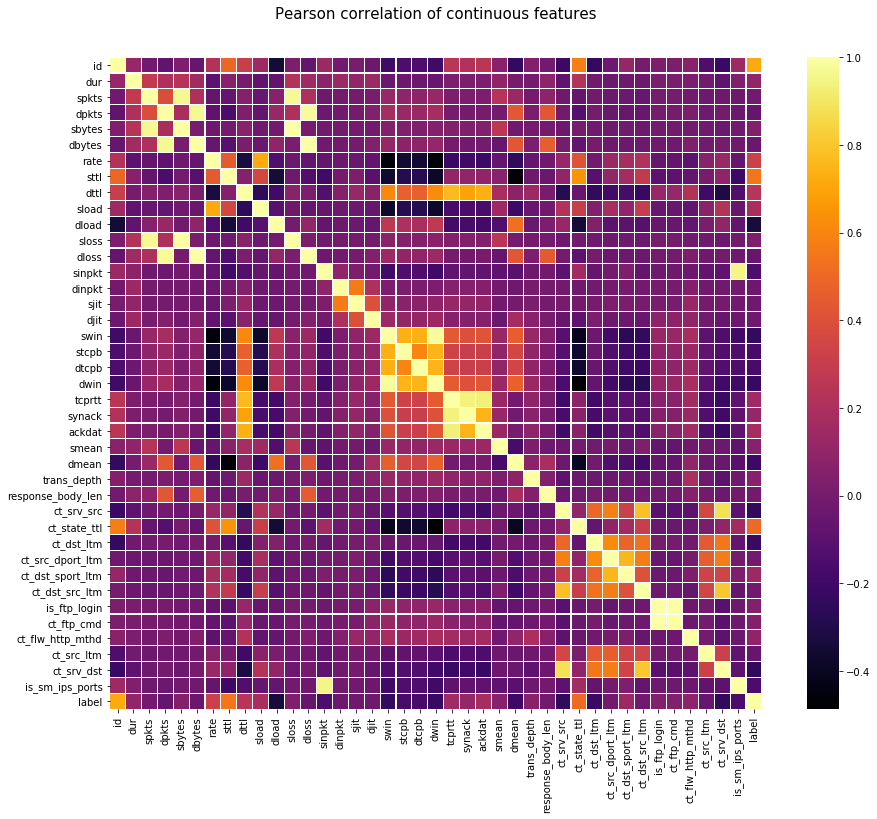

In [15]:
eda_utils.display_corr(df_train)

### Notes:
* Some pockes of high correlation

In [16]:
#doens't work with more than 10 ish columns
#eda_utils.display_scatter(df_sales_train)

Target Column Counts and Distribution: 
Normal      56000
Exploits    33393
DoS         12264
Analysis     2000
Backdoor     1746
Name: attack_cat, dtype: int64
Normal      53.1
Exploits    31.7
DoS         11.6
Analysis     1.9
Backdoor     1.7
Name: attack_cat, dtype: float64

id -- Feature 
count    105403.0
mean      62579.0
std       42538.0
min           1.0
25%       26352.0
50%       56381.0
75%       95348.0
max      175306.0
Name: id, dtype: float64


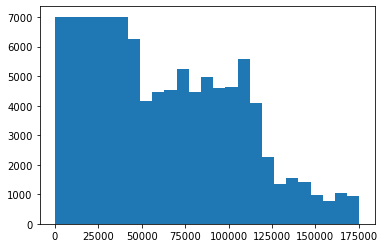

 | is numeric | 105403 unique values 

dur -- Feature 
count    105403.00
mean          1.63
std           6.95
min           0.00
25%           0.00
50%           0.05
75%           0.84
max          60.00
Name: dur, dtype: float64


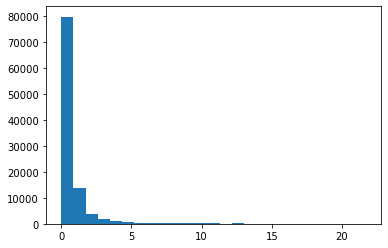

 | is numeric | 57405 unique values 

proto -- Feature 
 | is not numeric | 133 unique values  | consider one-hot?

service -- Feature 
 | is not numeric | 13 unique values  | consider one-hot?
target percentages:  Normal      53.1
Exploits    31.7
DoS         11.6
Analysis     1.9
Backdoor     1.7
Name: attack_cat, dtype: float64
                     service
service  attack_cat         
-        Analysis        2.1
         Backdoor        2.4
         DoS            15.6
         Exploits       25.6
         Normal         54.3
dhcp     DoS            38.8
         Exploits       61.2
dns      DoS             1.4
         Exploits        2.4
         Normal         96.2
ftp      Backdoor        0.2
         DoS             1.7
         Exploits       55.9
         Normal         42.2
ftp-data DoS             0.2
         Exploits       35.9
         Normal         63.9
http     Analysis        3.5
         Backdoor        0.5
         DoS             7.7
         Exploits       54.6


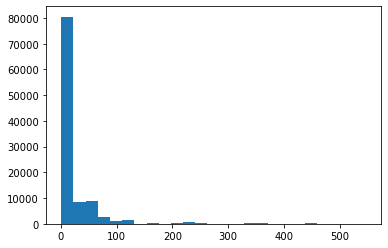

 | is numeric | 472 unique values  | consider one-hot? (ordinal?) 

dpkts -- Feature 
count    105403.00
mean         29.49
std         136.19
min           0.00
25%           0.00
50%           8.00
75%          20.00
max       10974.00
Name: dpkts, dtype: float64


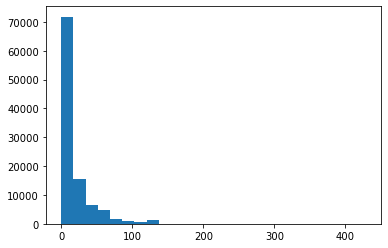

 | is numeric | 431 unique values  | consider one-hot? (ordinal?) 

sbytes -- Feature 
count      105403.0
mean        13221.0
std        223925.0
min            28.0
25%           200.0
50%           828.0
75%          2516.0
max      12965233.0
Name: sbytes, dtype: float64


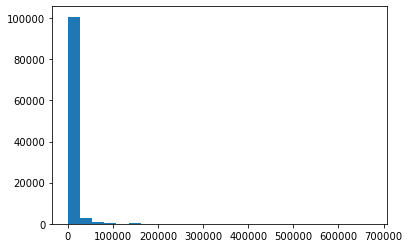

 | is numeric | 6675 unique values 

dbytes -- Feature 
count      105403.0
mean        24008.0
std        177792.0
min             0.0
25%             0.0
50%           354.0
75%          3193.0
max      14655550.0
Name: dbytes, dtype: float64


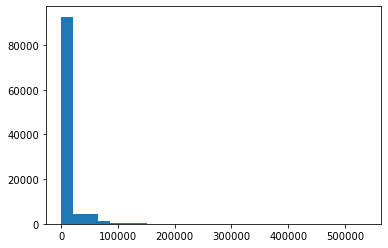

 | is numeric | 6469 unique values 

rate -- Feature 
count     105403.0
mean       53399.0
std       131526.0
min            0.0
25%           29.0
50%          781.0
75%        10625.0
max      1000000.0
Name: rate, dtype: float64


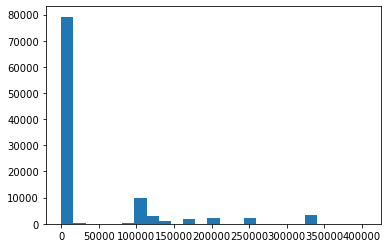

 | is numeric | 59994 unique values 

sttl -- Feature 
count    105403.0
mean        131.0
std         107.0
min           0.0
25%          31.0
50%          62.0
75%         254.0
max         255.0
Name: sttl, dtype: float64


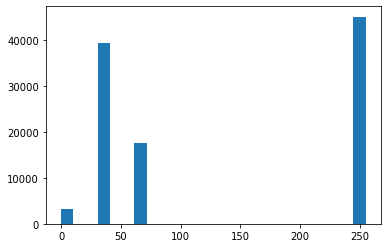

 | is numeric | 11 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      53.1
Exploits    31.7
DoS         11.6
Analysis     1.9
Backdoor     1.7
Name: attack_cat, dtype: float64
                  sttl
sttl attack_cat       
0    Analysis      0.1
     Backdoor      0.5
     DoS           2.3
     Exploits      5.5
     Normal       91.6
1    Normal      100.0
29   Normal      100.0
31   Normal      100.0
60   Normal      100.0
62   Analysis      3.2
     Backdoor      0.2
     DoS           7.2
     Exploits     76.9
     Normal       12.5
63   Normal      100.0
64   Normal      100.0
252  Normal      100.0
254  Analysis      3.2
     Backdoor      3.8
     DoS          24.2
     Exploits     44.0
     Normal       24.9
255  DoS          83.3
     Normal       16.7

dttl -- Feature 
count    105403.00
mean         89.31
std         109.65
min           0.00
25%           0.00
50%          29.00
75%         252.00
max         254.00
Name: dttl, dtype: float64


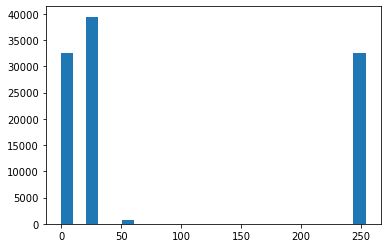

 | is numeric | 6 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      53.1
Exploits    31.7
DoS         11.6
Analysis     1.9
Backdoor     1.7
Name: attack_cat, dtype: float64
                  dttl
dttl attack_cat       
0    Analysis      4.4
     Backdoor      4.4
     DoS          30.0
     Exploits     40.6
     Normal       20.7
29   Normal      100.0
31   Normal      100.0
60   Analysis      1.0
     Backdoor      7.3
     DoS          28.6
     Exploits     53.9
     Normal        9.1
252  Analysis      1.7
     Backdoor      0.8
     DoS           7.0
     Exploits     60.6
     Normal       29.8
254  Normal      100.0

sload -- Feature 
count    1.054030e+05
mean     5.178371e+07
std      1.613947e+08
min      0.000000e+00
25%      1.107800e+04
50%      3.950050e+05
75%      1.632653e+07
max      5.344000e+09
Name: sload, dtype: float64


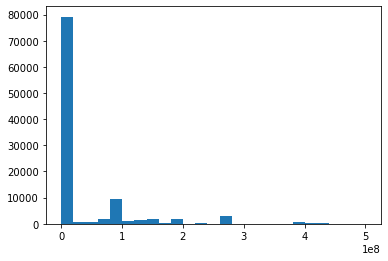

 | is numeric | 62520 unique values 

dload -- Feature 
count      105403.0
mean      1114761.0
std       3042806.0
min             0.0
25%             0.0
50%          8387.0
75%        598799.0
max      22422730.0
Name: dload, dtype: float64


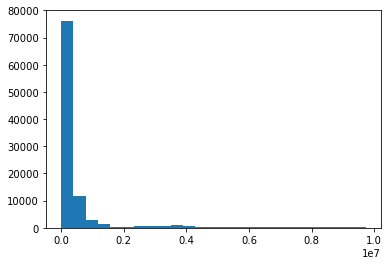

 | is numeric | 60664 unique values 

sloss -- Feature 
count    105403.00
mean          7.39
std          84.52
min           0.00
25%           0.00
50%           2.00
75%           6.00
max        4803.00
Name: sloss, dtype: float64


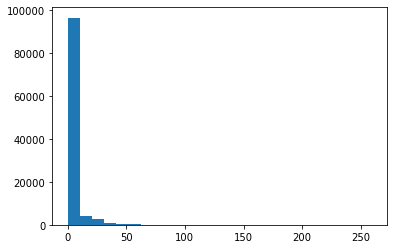

 | is numeric | 398 unique values  | consider one-hot? (ordinal?) 

dloss -- Feature 
count    105403.00
mean         11.03
std          65.11
min           0.00
25%           0.00
50%           1.00
75%           6.00
max        5484.00
Name: dloss, dtype: float64


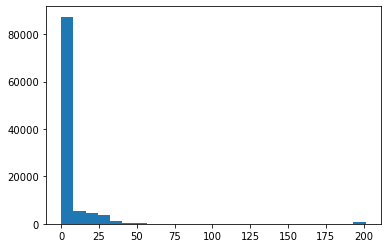

 | is numeric | 358 unique values  | consider one-hot? (ordinal?) 

sinpkt -- Feature 
count    105403.0
mean       1559.0
std        9226.0
min           0.0
25%           0.0
50%           2.0
75%          66.0
max       60010.0
Name: sinpkt, dtype: float64


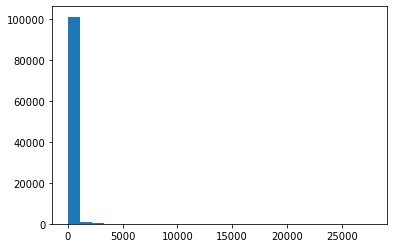

 | is numeric | 59196 unique values 

dinpkt -- Feature 
count    105403.00
mean         88.75
std        1130.00
min           0.00
25%           0.00
50%           0.70
75%          54.87
max       56716.82
Name: dinpkt, dtype: float64


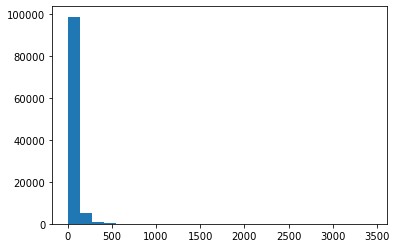

 | is numeric | 57491 unique values 

sjit -- Feature 
count     105403.0
mean        4421.0
std        40150.0
min            0.0
25%            0.0
50%           64.0
75%         2965.0
max      1460480.0
Name: sjit, dtype: float64


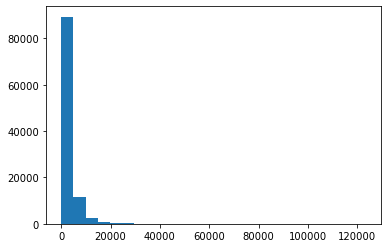

 | is numeric | 60392 unique values 

djit -- Feature 
count    105403.0
mean        851.0
std        4905.0
min           0.0
25%           0.0
50%          16.0
75%         140.0
max      289388.0
Name: djit, dtype: float64


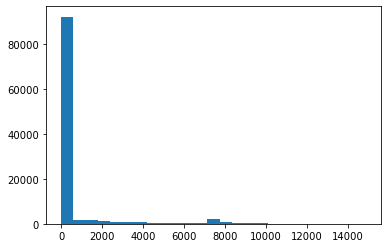

 | is numeric | 59931 unique values 

swin -- Feature 
count    105403.0
mean        150.0
std         126.0
min           0.0
25%           0.0
50%         255.0
75%         255.0
max         255.0
Name: swin, dtype: float64


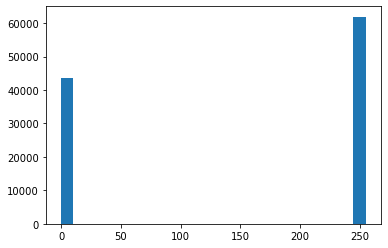

 | is numeric | 13 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      53.1
Exploits    31.7
DoS         11.6
Analysis     1.9
Backdoor     1.7
Name: attack_cat, dtype: float64
                  swin
swin attack_cat       
0    Analysis      3.3
     Backdoor      3.4
     DoS          23.0
     Exploits     31.5
     Normal       38.8
14   Normal      100.0
31   Normal      100.0
42   Normal      100.0
45   Normal      100.0
87   Normal      100.0
103  Normal      100.0
167  Normal      100.0
168  Normal      100.0
172  Normal      100.0
192  Normal      100.0
232  Normal      100.0
255  Analysis      0.9
     Backdoor      0.4
     DoS           3.7
     Exploits     31.8
     Normal       63.2

stcpb -- Feature 
count    1.054030e+05
mean     1.247119e+09
std      1.421707e+09
min      0.000000e+00
25%      0.000000e+00
50%      5.899196e+08
75%      2.452709e+09
max      4.294959e+09
Name: stcpb, dtype: float64


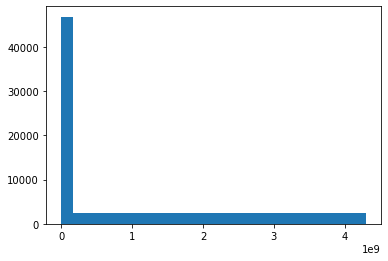

 | is numeric | 58335 unique values 

dtcpb -- Feature 
count    1.054030e+05
mean     1.243985e+09
std      1.417126e+09
min      0.000000e+00
25%      0.000000e+00
50%      5.954720e+08
75%      2.445421e+09
max      4.294882e+09
Name: dtcpb, dtype: float64


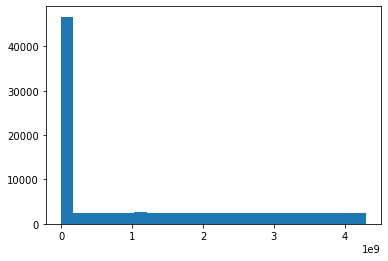

 | is numeric | 58235 unique values 

dwin -- Feature 
count    105403.0
mean        148.0
std         126.0
min           0.0
25%           0.0
50%         255.0
75%         255.0
max         255.0
Name: dwin, dtype: float64


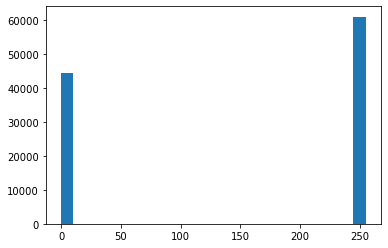

 | is numeric | 7 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      53.1
Exploits    31.7
DoS         11.6
Analysis     1.9
Backdoor     1.7
Name: attack_cat, dtype: float64
                  dwin
dwin attack_cat       
0    Analysis      3.2
     Backdoor      3.3
     DoS          22.5
     Exploits     30.9
     Normal       40.0
37   Normal      100.0
40   Normal      100.0
48   Normal      100.0
70   Normal      100.0
244  Normal      100.0
255  Analysis      0.9
     Backdoor      0.4
     DoS           3.7
     Exploits     32.2
     Normal       62.7

tcprtt -- Feature 
count    105403.00
mean          0.04
std           0.08
min           0.00
25%           0.00
50%           0.00
75%           0.07
max           2.52
Name: tcprtt, dtype: float64


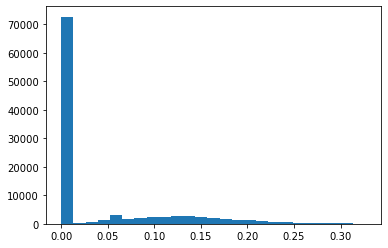

 | is numeric | 29287 unique values 

synack -- Feature 
count    105403.00
mean          0.02
std           0.05
min           0.00
25%           0.00
50%           0.00
75%           0.03
max           2.10
Name: synack, dtype: float64


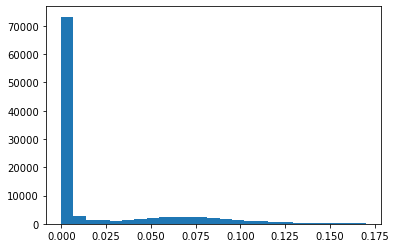

 | is numeric | 27729 unique values 

ackdat -- Feature 
count    105403.00
mean          0.02
std           0.04
min           0.00
25%           0.00
50%           0.00
75%           0.04
max           1.52
Name: ackdat, dtype: float64


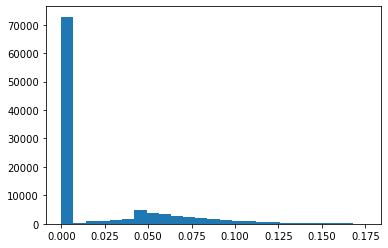

 | is numeric | 26166 unique values 

smean -- Feature 
count    105403.0
mean        152.0
std         213.0
min          28.0
25%          62.0
50%          93.0
75%         113.0
max        1499.0
Name: smean, dtype: float64


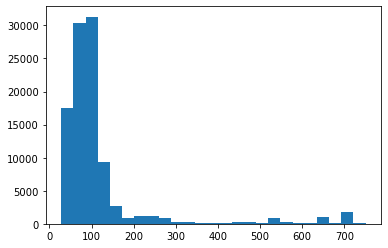

 | is numeric | 1321 unique values  | consider one-hot? (ordinal?) 

dmean -- Feature 
count    105403.0
mean        195.0
std         309.0
min           0.0
25%           0.0
50%          76.0
75%         146.0
max        1458.0
Name: dmean, dtype: float64


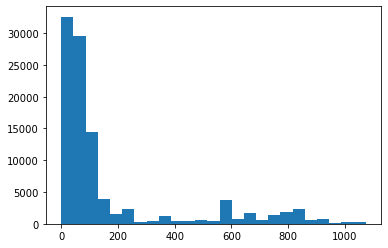

 | is numeric | 1320 unique values  | consider one-hot? (ordinal?) 

trans_depth -- Feature 
count    105403.00
mean          0.15
std           0.99
min           0.00
25%           0.00
50%           0.00
75%           0.00
max         172.00
Name: trans_depth, dtype: float64


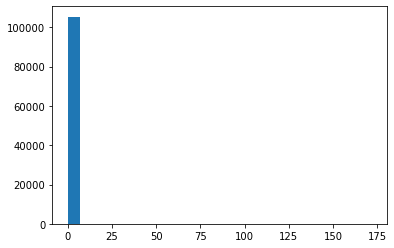

 | is numeric | 11 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      53.1
Exploits    31.7
DoS         11.6
Analysis     1.9
Backdoor     1.7
Name: attack_cat, dtype: float64
                        trans_depth
trans_depth attack_cat             
0           Analysis            1.6
            Backdoor            1.8
            DoS                12.3
            Exploits           28.1
            Normal             56.2
1           Analysis            3.7
            Backdoor            0.5
            DoS                 7.7
            Exploits           53.7
            Normal             34.4
2           Exploits           13.8
            Normal             86.2
3           DoS                50.0
            Exploits           50.0
4           DoS                33.3
            Exploits           66.7
5           DoS                50.0
            Exploits           50.0
39          Exploits          100.0
80          Exploits          100.0
155

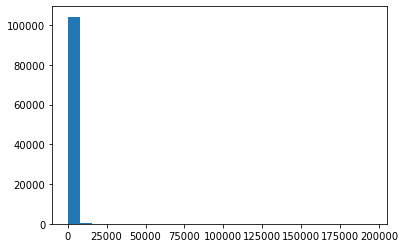

 | is numeric | 2300 unique values  | consider one-hot? (ordinal?) 

ct_srv_src -- Feature 
count    105403.00
mean          4.60
std           4.91
min           1.00
25%           1.00
50%           3.00
75%           6.00
max          63.00
Name: ct_srv_src, dtype: float64


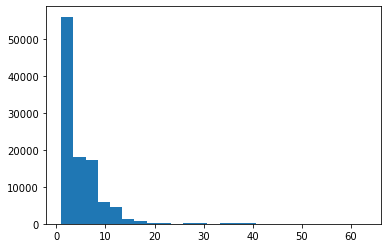

 | is numeric | 45 unique values  | consider one-hot? (ordinal?) 

ct_state_ttl -- Feature 
count    105403.00
mean          1.00
std           1.04
min           0.00
25%           0.00
50%           1.00
75%           2.00
max           6.00
Name: ct_state_ttl, dtype: float64


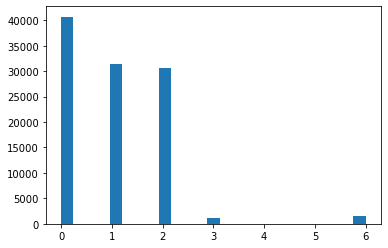

 | is numeric | 5 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      53.1
Exploits    31.7
DoS         11.6
Analysis     1.9
Backdoor     1.7
Name: attack_cat, dtype: float64
                         ct_state_ttl
ct_state_ttl attack_cat              
0            Analysis             0.0
             Backdoor             0.1
             DoS                  0.7
             Exploits             1.1
             Normal              98.1
1            Analysis             1.8
             Backdoor             0.9
             DoS                  7.1
             Exploits            62.5
             Normal              27.8
2            Analysis             4.6
             Backdoor             4.5
             DoS                 31.0
             Exploits            41.9
             Normal              18.0
3            DoS                  2.7
             Exploits            12.9
             Normal              84.4
6            Analysis             1.

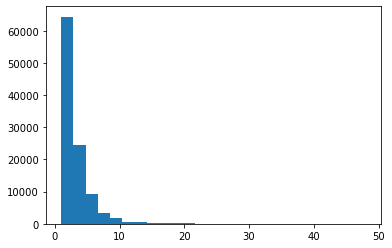

 | is numeric | 46 unique values  | consider one-hot? (ordinal?) 

ct_src_dport_ltm -- Feature 
count    105403.00
mean          1.76
std           2.19
min           1.00
25%           1.00
50%           1.00
75%           2.00
max          46.00
Name: ct_src_dport_ltm, dtype: float64


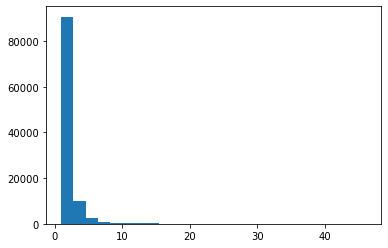

 | is numeric | 27 unique values  | consider one-hot? (ordinal?) 

ct_dst_sport_ltm -- Feature 
count    105403.00
mean          1.42
std           1.72
min           1.00
25%           1.00
50%           1.00
75%           1.00
max          46.00
Name: ct_dst_sport_ltm, dtype: float64


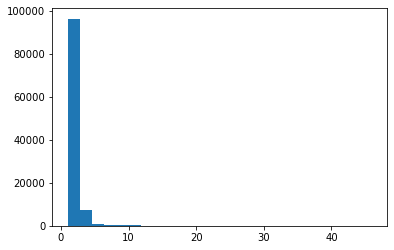

 | is numeric | 16 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      53.1
Exploits    31.7
DoS         11.6
Analysis     1.9
Backdoor     1.7
Name: attack_cat, dtype: float64
                             ct_dst_sport_ltm
ct_dst_sport_ltm attack_cat                  
1                Analysis                 0.9
                 Backdoor                 0.9
                 DoS                      6.8
                 Exploits                29.6
                 Normal                  61.9
2                Analysis                 4.7
                 Backdoor                 3.7
                 DoS                     24.9
                 Exploits                35.7
                 Normal                  31.0
3                Analysis                 7.1
                 Backdoor                 5.8
                 DoS                     37.1
                 Exploits                46.5
                 Normal                   3.6
4            

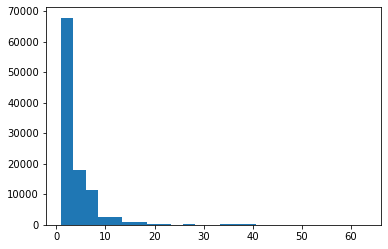

 | is numeric | 49 unique values  | consider one-hot? (ordinal?) 

is_ftp_login -- Feature 
count    105403.00
mean          0.02
std           0.16
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           4.00
Name: is_ftp_login, dtype: float64


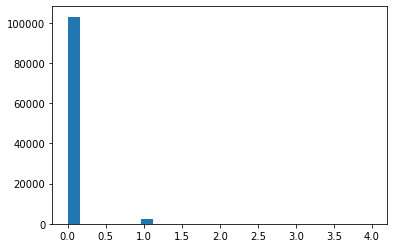

 | is numeric | 4 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      53.1
Exploits    31.7
DoS         11.6
Analysis     1.9
Backdoor     1.7
Name: attack_cat, dtype: float64
                         is_ftp_login
is_ftp_login attack_cat              
0            Analysis             1.9
             Backdoor             1.7
             DoS                 11.9
             Exploits            31.0
             Normal              53.5
1            DoS                  0.7
             Exploits            60.1
             Normal              39.2
2            Normal             100.0
4            Exploits           100.0

ct_ftp_cmd -- Feature 
count    105403.00
mean          0.02
std           0.16
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           4.00
Name: ct_ftp_cmd, dtype: float64


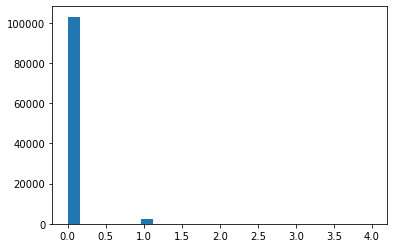

 | is numeric | 4 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      53.1
Exploits    31.7
DoS         11.6
Analysis     1.9
Backdoor     1.7
Name: attack_cat, dtype: float64
                       ct_ftp_cmd
ct_ftp_cmd attack_cat            
0          Analysis           1.9
           Backdoor           1.7
           DoS               11.9
           Exploits          31.0
           Normal            53.5
1          DoS                0.7
           Exploits          60.1
           Normal            39.2
2          Normal           100.0
4          Exploits         100.0

ct_flw_http_mthd -- Feature 
count    105403.00
mean          0.19
std           0.87
min           0.00
25%           0.00
50%           0.00
75%           0.00
max          30.00
Name: ct_flw_http_mthd, dtype: float64


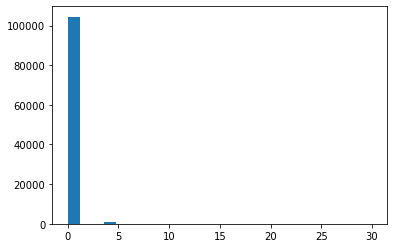

 | is numeric | 11 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      53.1
Exploits    31.7
DoS         11.6
Analysis     1.9
Backdoor     1.7
Name: attack_cat, dtype: float64
                             ct_flw_http_mthd
ct_flw_http_mthd attack_cat                  
0                Analysis                 1.6
                 Backdoor                 1.8
                 DoS                     12.3
                 Exploits                28.1
                 Normal                  56.2
1                Analysis                 1.9
                 Backdoor                 0.5
                 DoS                      7.8
                 Exploits                55.6
                 Normal                  34.3
2                Analysis                 4.8
                 DoS                     28.6
                 Exploits                28.6
                 Normal                  38.1
3                Exploits               100.0
4            

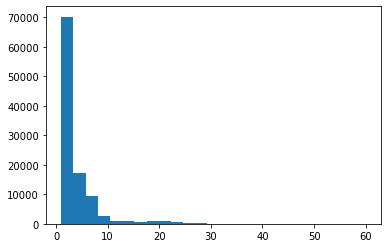

 | is numeric | 48 unique values  | consider one-hot? (ordinal?) 

ct_srv_dst -- Feature 
count    105403.00
mean          4.42
std           4.80
min           1.00
25%           1.00
50%           3.00
75%           6.00
max          62.00
Name: ct_srv_dst, dtype: float64


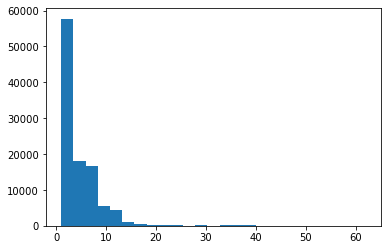

 | is numeric | 45 unique values  | consider one-hot? (ordinal?) 

is_sm_ips_ports -- Feature 
count    105403.00
mean          0.03
std           0.16
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           1.00
Name: is_sm_ips_ports, dtype: float64


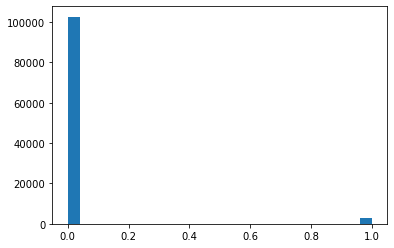

 | is numeric | 2 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      53.1
Exploits    31.7
DoS         11.6
Analysis     1.9
Backdoor     1.7
Name: attack_cat, dtype: float64
                            is_sm_ips_ports
is_sm_ips_ports attack_cat                 
0               Analysis                1.9
                Backdoor                1.7
                DoS                    11.9
                Exploits               32.5
                Normal                 51.9
1               Normal                100.0

attack_cat -- Feature 
 | is not numeric | 5 unique values  | consider one-hot?
target percentages:  Normal      53.1
Exploits    31.7
DoS         11.6
Analysis     1.9
Backdoor     1.7
Name: attack_cat, dtype: float64
                       attack_cat
attack_cat attack_cat            
Analysis   Analysis         100.0
Backdoor   Backdoor         100.0
DoS        DoS              100.0
Exploits   Exploits         100.0
Normal     Normal   

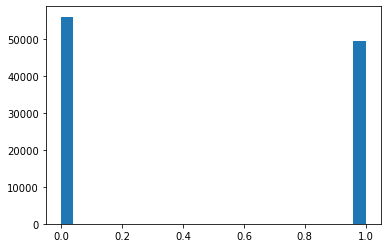

 | is numeric | 2 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      53.1
Exploits    31.7
DoS         11.6
Analysis     1.9
Backdoor     1.7
Name: attack_cat, dtype: float64
                  label
label attack_cat       
0     Normal      100.0
1     Analysis      4.0
      Backdoor      3.5
      DoS          24.8
      Exploits     67.6


In [17]:
#def describe_features(df, target_column, is_target_categorical, is_violin_plot=True):
eda_utils.describe_features(df_train,'attack_cat', True, False)

### Notes:
* Target columnn is unbalanced and also differs from the test column distribution
* Some features have extreme outliers
* for each potential categorical/one hot variable, get the exact counts for each 'label' and not just the %
* Categorical variables: service, state, proto. Can one-hot service and state but proto has many different levels.
* Some of the 'state' features are in certain attack_cat. ie 'ECO' is 100% Normal while 'INT' is 19% Normal, I
* Some variables like sttl, swin, and dwin appear to have non-normal attack_cat at a much higher rate at their extreme min and max values. May make sense to do mean encoding or binning


Name: attack_cat, dtype: int64
* Normal      53.1
* Exploits    31.7
* DoS         11.6
* Analysis     1.9
* Backdoor     1.7

Target Column Counts and Distribution: 
Normal      37000
Exploits    11132
DoS          4089
Analysis      677
Backdoor      583
Name: attack_cat, dtype: int64
Normal      69.2
Exploits    20.8
DoS          7.6
Analysis     1.3
Backdoor     1.1
Name: attack_cat, dtype: float64

id -- Feature 
count    53481.0
mean     44238.0
std      24599.0
min          1.0
25%      27643.0
50%      41013.0
75%      68962.0
max      82332.0
Name: id, dtype: float64


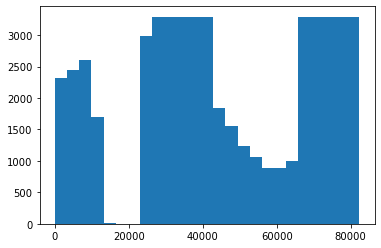

 | is numeric | 53481 unique values 

dur -- Feature 
count    53481.00
mean         1.23
std          5.04
min          0.00
25%          0.00
50%          0.25
75%          0.91
max         60.00
Name: dur, dtype: float64


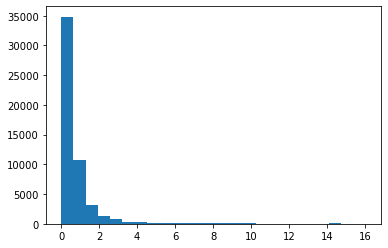

 | is numeric | 33996 unique values 

proto -- Feature 
 | is not numeric | 131 unique values  | consider one-hot?

service -- Feature 
 | is not numeric | 13 unique values  | consider one-hot?
target percentages:  Normal      69.2
Exploits    20.8
DoS          7.6
Analysis     1.3
Backdoor     1.1
Name: attack_cat, dtype: float64
                     service
service  attack_cat         
-        Analysis        1.8
         Backdoor        1.5
         DoS             8.9
         Exploits       15.4
         Normal         72.4
dhcp     DoS            42.9
         Exploits       57.1
dns      DoS             1.3
         Exploits        2.1
         Normal         96.6
ftp      Backdoor        0.2
         DoS             1.8
         Exploits       39.0
         Normal         59.1
ftp-data DoS             0.4
         Exploits       31.6
         Normal         68.0
http     Backdoor        0.1
         DoS             6.7
         Exploits       38.3
         Normal         54.8


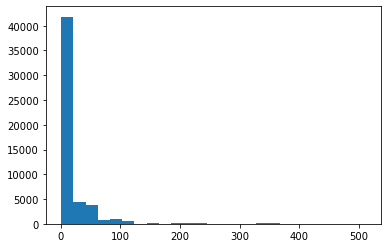

 | is numeric | 415 unique values  | consider one-hot? (ordinal?) 

dpkts -- Feature 
count    53481.00
mean        25.44
std        140.89
min          0.00
25%          0.00
50%          8.00
75%         18.00
max      11018.00
Name: dpkts, dtype: float64


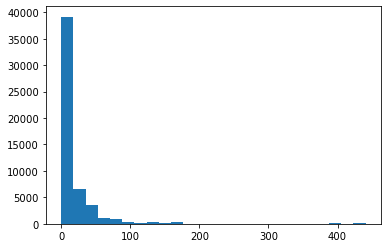

 | is numeric | 419 unique values  | consider one-hot? (ordinal?) 

sbytes -- Feature 
count       53481.0
mean        11472.0
std        211968.0
min            24.0
25%           200.0
50%           840.0
75%          2100.0
max      14355774.0
Name: sbytes, dtype: float64


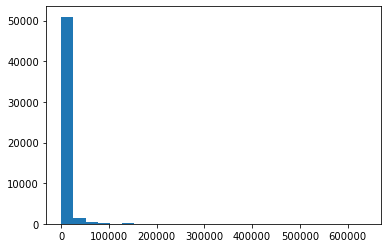

 | is numeric | 4097 unique values 

dbytes -- Feature 
count       53481.0
mean        19590.0
std        185004.0
min             0.0
25%             0.0
50%           354.0
75%          1860.0
max      14657531.0
Name: dbytes, dtype: float64


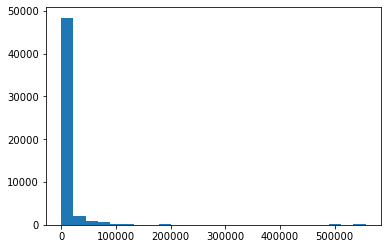

 | is numeric | 3826 unique values 

rate -- Feature 
count      53481.0
mean       43993.0
std       116573.0
min            0.0
25%           25.0
50%           87.0
75%         5142.0
max      1000000.0
Name: rate, dtype: float64


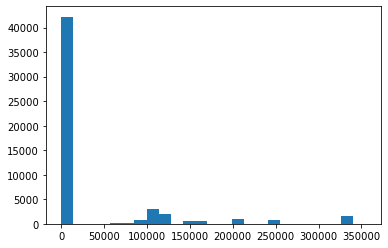

 | is numeric | 34646 unique values 

sttl -- Feature 
count    53481.0
mean       142.0
std        107.0
min          0.0
25%         31.0
50%         62.0
75%        254.0
max        255.0
Name: sttl, dtype: float64


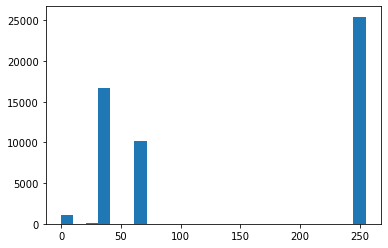

 | is numeric | 11 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      69.2
Exploits    20.8
DoS          7.6
Analysis     1.3
Backdoor     1.1
Name: attack_cat, dtype: float64
                  sttl
sttl attack_cat       
0    Backdoor      0.6
     DoS           3.5
     Exploits      1.2
     Normal       94.8
1    Normal      100.0
29   Normal      100.0
30   Normal      100.0
31   Normal      100.0
32   Normal      100.0
60   Normal      100.0
62   Analysis      0.6
     Backdoor      0.1
     DoS           5.6
     Exploits     53.0
     Normal       40.7
63   Exploits    100.0
254  Analysis      2.4
     Backdoor      2.2
     DoS          13.7
     Exploits     22.6
     Normal       59.1
255  DoS          60.0
     Exploits     40.0

dttl -- Feature 
count    53481.0
mean       117.0
std        117.0
min          0.0
25%          0.0
50%         29.0
75%        252.0
max        253.0
Name: dttl, dtype: float64


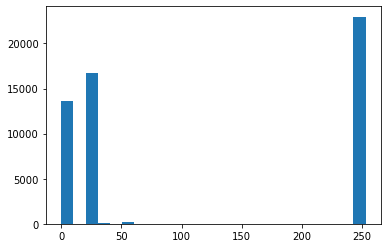

 | is numeric | 8 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      69.2
Exploits    20.8
DoS          7.6
Analysis     1.3
Backdoor     1.1
Name: attack_cat, dtype: float64
                  dttl
dttl attack_cat       
0    Analysis      4.6
     Backdoor      3.9
     DoS          21.8
     Exploits     23.7
     Normal       46.1
29   Normal      100.0
30   Normal      100.0
31   Normal      100.0
32   Normal      100.0
60   Backdoor      3.1
     DoS          37.0
     Exploits     59.4
     Normal        0.5
252  Analysis      0.3
     Backdoor      0.2
     DoS           4.6
     Exploits     33.9
     Normal       61.0
253  DoS          28.6
     Exploits     71.4

sload -- Feature 
count    5.348100e+04
mean     4.947304e+07
std      1.864712e+08
min      0.000000e+00
25%      8.678000e+03
50%      8.241800e+04
75%      1.747516e+06
max      5.268000e+09
Name: sload, dtype: float64


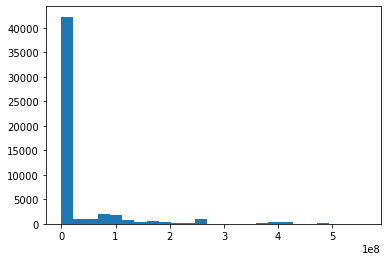

 | is numeric | 36290 unique values 

dload -- Feature 
count       53481.0
mean       967887.0
std       2913522.0
min             0.0
25%             0.0
50%          5476.0
75%        275985.0
max      20821108.0
Name: dload, dtype: float64


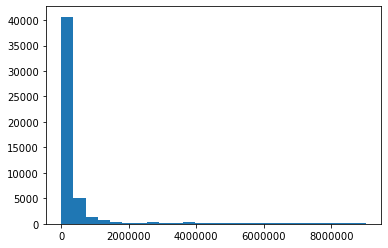

 | is numeric | 34696 unique values 

sloss -- Feature 
count    53481.00
mean         6.78
std         79.77
min          0.00
25%          0.00
50%          2.00
75%          4.00
max       5319.00
Name: sloss, dtype: float64


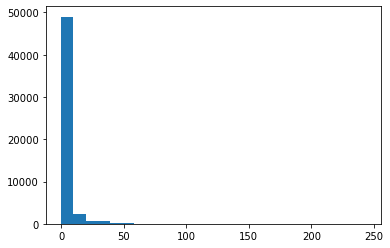

 | is numeric | 247 unique values  | consider one-hot? (ordinal?) 

dloss -- Feature 
count    53481.00
mean         9.26
std         68.00
min          0.00
25%          0.00
50%          1.00
75%          4.00
max       5507.00
Name: dloss, dtype: float64


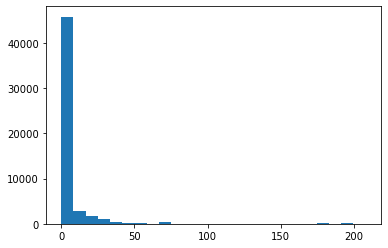

 | is numeric | 296 unique values  | consider one-hot? (ordinal?) 

sinpkt -- Feature 
count    53481.0
mean      1115.0
std       7613.0
min          0.0
25%          0.0
50%         20.0
75%         78.0
max      60010.0
Name: sinpkt, dtype: float64


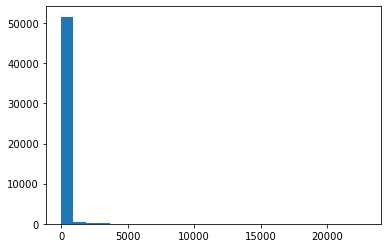

 | is numeric | 34023 unique values 

dinpkt -- Feature 
count    53481.0
mean       136.0
std       1431.0
min          0.0
25%          0.0
50%          2.0
75%         74.0
max      57739.0
Name: dinpkt, dtype: float64


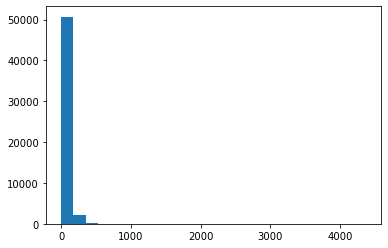

 | is numeric | 31737 unique values 

sjit -- Feature 
count      53481.0
mean        6476.0
std        55459.0
min            0.0
25%            0.0
50%          896.0
75%         3960.0
max      1483831.0
Name: sjit, dtype: float64


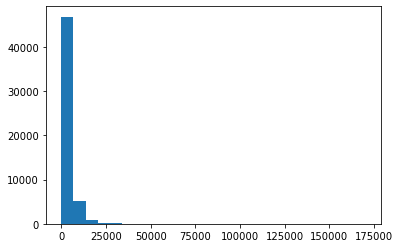

 | is numeric | 33958 unique values 

djit -- Feature 
count     53481.0
mean        677.0
std        3903.0
min           0.0
25%           0.0
50%          34.0
75%         163.0
max      463199.0
Name: djit, dtype: float64


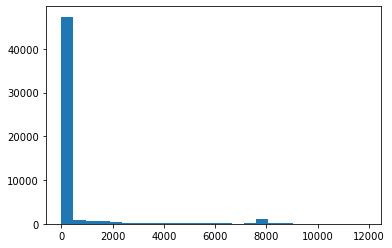

 | is numeric | 32464 unique values 

swin -- Feature 
count    53481.0
mean       175.0
std        118.0
min          0.0
25%          0.0
50%        255.0
75%        255.0
max        255.0
Name: swin, dtype: float64


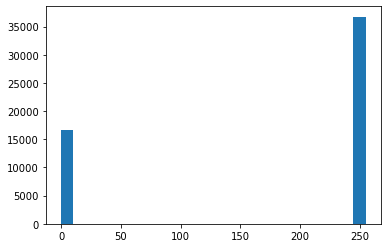

 | is numeric | 11 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      69.2
Exploits    20.8
DoS          7.6
Analysis     1.3
Backdoor     1.1
Name: attack_cat, dtype: float64
                  swin
swin attack_cat       
0    Analysis      3.7
     Backdoor      3.2
     DoS          18.2
     Exploits     20.2
     Normal       54.8
5    Normal      100.0
43   Normal      100.0
52   Normal      100.0
67   Normal      100.0
99   Normal      100.0
154  Normal      100.0
156  Normal      100.0
202  Normal      100.0
245  Normal      100.0
255  Analysis      0.2
     Backdoor      0.1
     DoS           2.9
     Exploits     21.1
     Normal       75.7

stcpb -- Feature 
count    5.348100e+04
mean     1.411844e+09
std      1.432481e+09
min      0.000000e+00
25%      0.000000e+00
50%      1.030841e+09
75%      2.657545e+09
max      4.294950e+09
Name: stcpb, dtype: float64


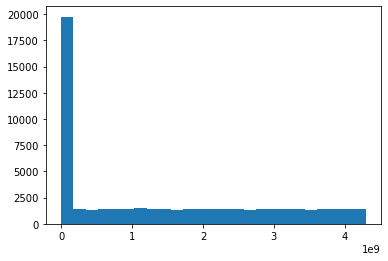

 | is numeric | 33287 unique values 

dtcpb -- Feature 
count    5.348100e+04
mean     1.399375e+09
std      1.425904e+09
min      0.000000e+00
25%      0.000000e+00
50%      1.002866e+09
75%      2.632227e+09
max      4.294881e+09
Name: dtcpb, dtype: float64


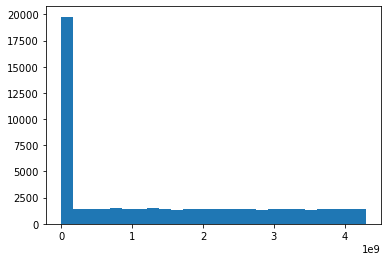

 | is numeric | 33201 unique values 

dwin -- Feature 
count    53481.0
mean       167.0
std        121.0
min          0.0
25%          0.0
50%        255.0
75%        255.0
max        255.0
Name: dwin, dtype: float64


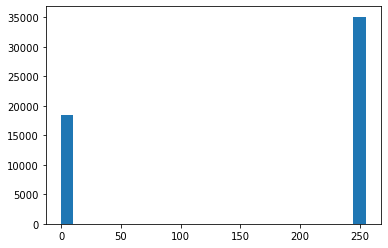

 | is numeric | 14 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      69.2
Exploits    20.8
DoS          7.6
Analysis     1.3
Backdoor     1.1
Name: attack_cat, dtype: float64
                  dwin
dwin attack_cat       
0    Analysis      3.4
     Backdoor      2.9
     DoS          16.5
     Exploits     18.4
     Normal       58.8
12   Normal      100.0
27   Normal      100.0
33   Normal      100.0
46   Normal      100.0
77   Normal      100.0
81   Normal      100.0
125  Normal      100.0
137  Normal      100.0
160  Normal      100.0
164  Normal      100.0
171  Normal      100.0
209  Normal      100.0
255  Analysis      0.2
     Backdoor      0.1
     DoS           3.0
     Exploits     22.1
     Normal       74.6

tcprtt -- Feature 
count    53481.00
mean         0.07
std          0.13
min          0.00
25%          0.00
50%          0.00
75%          0.13
max          3.82
Name: tcprtt, dtype: float64


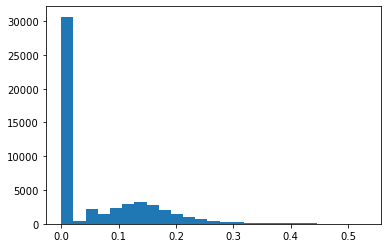

 | is numeric | 20942 unique values 

synack -- Feature 
count    53481.00
mean         0.04
std          0.08
min          0.00
25%          0.00
50%          0.00
75%          0.07
max          3.23
Name: synack, dtype: float64


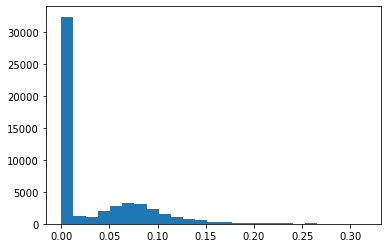

 | is numeric | 20142 unique values 

ackdat -- Feature 
count    53481.00
mean         0.03
std          0.06
min          0.00
25%          0.00
50%          0.00
75%          0.06
max          2.93
Name: ackdat, dtype: float64


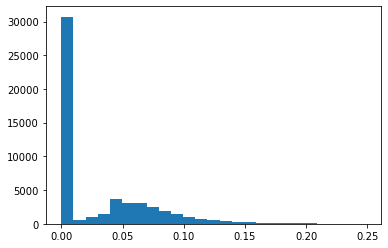

 | is numeric | 19448 unique values 

smean -- Feature 
count    53481.0
mean       161.0
std        228.0
min         24.0
25%         59.0
50%         83.0
75%        130.0
max       1502.0
Name: smean, dtype: float64


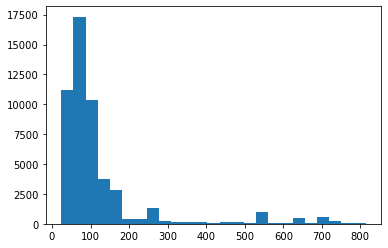

 | is numeric | 1221 unique values  | consider one-hot? (ordinal?) 

dmean -- Feature 
count    53481.0
mean       168.0
std        282.0
min          0.0
25%          0.0
50%         56.0
75%        124.0
max       1500.0
Name: dmean, dtype: float64


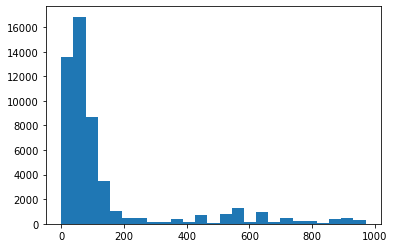

 | is numeric | 1191 unique values  | consider one-hot? (ordinal?) 

trans_depth -- Feature 
count    53481.00
mean         0.13
std          0.66
min          0.00
25%          0.00
50%          0.00
75%          0.00
max        131.00
Name: trans_depth, dtype: float64


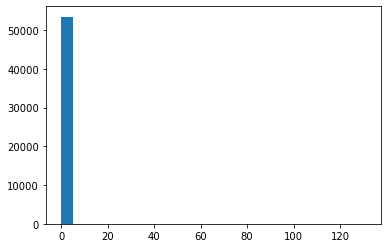

 | is numeric | 8 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      69.2
Exploits    20.8
DoS          7.6
Analysis     1.3
Backdoor     1.1
Name: attack_cat, dtype: float64
                        trans_depth
trans_depth attack_cat             
0           Analysis            1.5
            Backdoor            1.2
            DoS                 7.8
            Exploits           18.8
            Normal             70.6
1           Backdoor            0.1
            DoS                 6.3
            Exploits           34.1
            Normal             59.5
2           Backdoor            8.0
            DoS                 8.0
            Exploits           84.0
3           Exploits          100.0
4           Exploits          100.0
8           DoS               100.0
9           DoS               100.0
131         Exploits          100.0

response_body_len -- Feature 
count      53481.0
mean        2366.0
std        47022.0
min            0.0
25%  

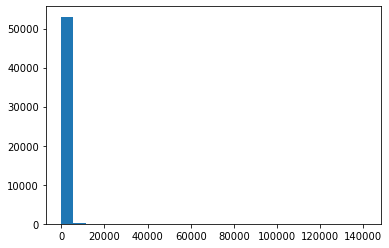

 | is numeric | 1115 unique values  | consider one-hot? (ordinal?) 

ct_srv_src -- Feature 
count    53481.00
mean         5.48
std          5.60
min          1.00
25%          2.00
50%          4.00
75%          7.00
max         49.00
Name: ct_srv_src, dtype: float64


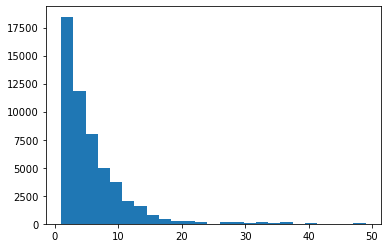

 | is numeric | 42 unique values  | consider one-hot? (ordinal?) 

ct_state_ttl -- Feature 
count    53481.00
mean         1.14
std          1.22
min          0.00
25%          0.00
50%          1.00
75%          2.00
max          6.00
Name: ct_state_ttl, dtype: float64


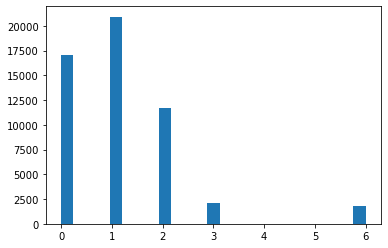

 | is numeric | 6 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      69.2
Exploits    20.8
DoS          7.6
Analysis     1.3
Backdoor     1.1
Name: attack_cat, dtype: float64
                         ct_state_ttl
ct_state_ttl attack_cat              
0            Backdoor             0.0
             DoS                  0.4
             Exploits             0.4
             Normal              99.3
1            Analysis             0.3
             Backdoor             0.2
             DoS                  4.9
             Exploits            36.9
             Normal              57.7
2            Analysis             5.3
             Backdoor             4.5
             DoS                 25.0
             Exploits            27.2
             Normal              38.1
3            Analysis             0.0
             Backdoor             0.2
             DoS                  2.0
             Exploits             5.6
             Normal              92.

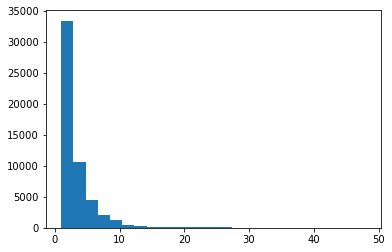

 | is numeric | 38 unique values  | consider one-hot? (ordinal?) 

ct_src_dport_ltm -- Feature 
count    53481.00
mean         1.81
std          1.80
min          1.00
25%          1.00
50%          1.00
75%          2.00
max         18.00
Name: ct_src_dport_ltm, dtype: float64


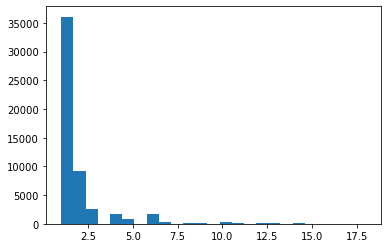

 | is numeric | 17 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      69.2
Exploits    20.8
DoS          7.6
Analysis     1.3
Backdoor     1.1
Name: attack_cat, dtype: float64
                             ct_src_dport_ltm
ct_src_dport_ltm attack_cat                  
1                Analysis                 0.2
                 Backdoor                 0.2
                 DoS                      5.0
                 Exploits                22.8
                 Normal                  71.8
2                Analysis                 2.5
                 Backdoor                 1.7
                 DoS                     12.7
                 Exploits                16.4
                 Normal                  66.8
3                Analysis                 0.9
                 Backdoor                 0.4
                 DoS                     17.3
                 Exploits                16.1
                 Normal                  65.3
4            

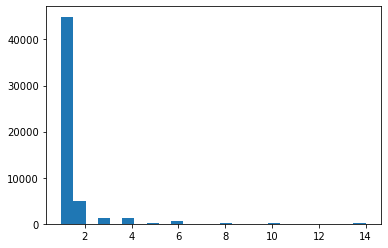

 | is numeric | 9 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      69.2
Exploits    20.8
DoS          7.6
Analysis     1.3
Backdoor     1.1
Name: attack_cat, dtype: float64
                             ct_dst_sport_ltm
ct_dst_sport_ltm attack_cat                  
1                Analysis                 0.2
                 Backdoor                 0.2
                 DoS                      4.1
                 Exploits                19.1
                 Normal                  76.4
2                Analysis                 4.3
                 Backdoor                 3.2
                 DoS                     22.7
                 Exploits                24.4
                 Normal                  45.5
3                Analysis                 2.2
                 Backdoor                 1.1
                 DoS                     38.0
                 Exploits                33.3
                 Normal                  25.4
4             

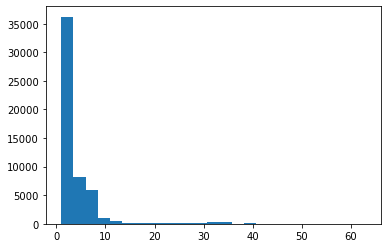

 | is numeric | 44 unique values  | consider one-hot? (ordinal?) 

is_ftp_login -- Feature 
count    53481.00
mean         0.01
std          0.11
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          2.00
Name: is_ftp_login, dtype: float64


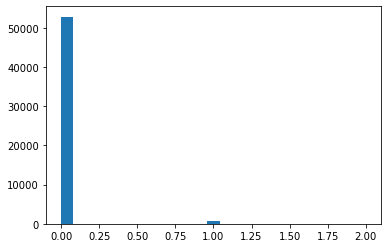

 | is numeric | 3 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      69.2
Exploits    20.8
DoS          7.6
Analysis     1.3
Backdoor     1.1
Name: attack_cat, dtype: float64
                         is_ftp_login
is_ftp_login attack_cat              
0            Analysis             1.3
             Backdoor             1.1
             DoS                  7.7
             Exploits            20.5
             Normal              69.4
1            DoS                  0.9
             Exploits            44.1
             Normal              55.0
2            Exploits           100.0

ct_ftp_cmd -- Feature 
count    53481.00
mean         0.01
std          0.11
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          2.00
Name: ct_ftp_cmd, dtype: float64


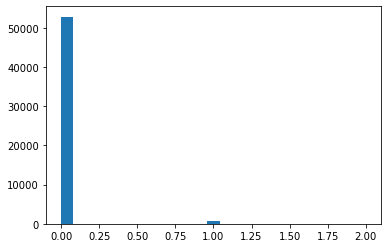

 | is numeric | 3 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      69.2
Exploits    20.8
DoS          7.6
Analysis     1.3
Backdoor     1.1
Name: attack_cat, dtype: float64
                       ct_ftp_cmd
ct_ftp_cmd attack_cat            
0          Analysis           1.3
           Backdoor           1.1
           DoS                7.7
           Exploits          20.5
           Normal            69.4
1          DoS                0.9
           Exploits          44.3
           Normal            54.8
2          Exploits          40.0
           Normal            60.0

ct_flw_http_mthd -- Feature 
count    53481.00
mean         0.19
std          0.78
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         16.00
Name: ct_flw_http_mthd, dtype: float64


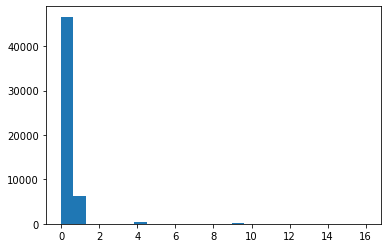

 | is numeric | 8 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      69.2
Exploits    20.8
DoS          7.6
Analysis     1.3
Backdoor     1.1
Name: attack_cat, dtype: float64
                             ct_flw_http_mthd
ct_flw_http_mthd attack_cat                  
0                Analysis                 1.5
                 Backdoor                 1.2
                 DoS                      7.8
                 Exploits                18.8
                 Normal                  70.6
1                Backdoor                 0.1
                 DoS                      6.9
                 Exploits                37.1
                 Normal                  55.9
2                DoS                     16.7
                 Normal                  83.3
4                DoS                      0.9
                 Exploits                 8.1
                 Normal                  91.0
6                Normal                 100.0
9             

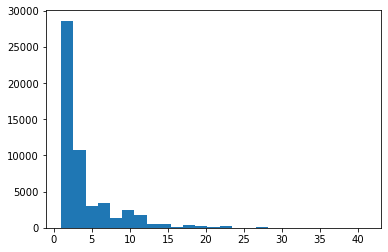

 | is numeric | 37 unique values  | consider one-hot? (ordinal?) 

ct_srv_dst -- Feature 
count    53481.00
mean         5.06
std          5.36
min          1.00
25%          2.00
50%          3.00
75%          7.00
max         48.00
Name: ct_srv_dst, dtype: float64


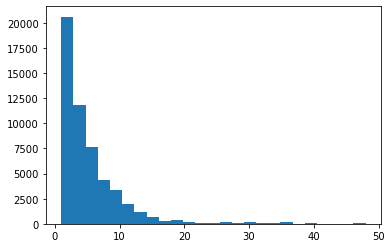

 | is numeric | 39 unique values  | consider one-hot? (ordinal?) 

is_sm_ips_ports -- Feature 
count    53481.00
mean         0.02
std          0.13
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: is_sm_ips_ports, dtype: float64


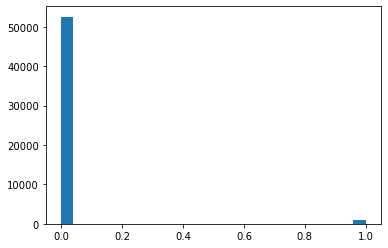

 | is numeric | 2 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      69.2
Exploits    20.8
DoS          7.6
Analysis     1.3
Backdoor     1.1
Name: attack_cat, dtype: float64
                            is_sm_ips_ports
is_sm_ips_ports attack_cat                 
0               Analysis                1.3
                Backdoor                1.1
                DoS                     7.8
                Exploits               21.2
                Normal                 68.6
1               Normal                100.0

attack_cat -- Feature 
 | is not numeric | 5 unique values  | consider one-hot?
target percentages:  Normal      69.2
Exploits    20.8
DoS          7.6
Analysis     1.3
Backdoor     1.1
Name: attack_cat, dtype: float64
                       attack_cat
attack_cat attack_cat            
Analysis   Analysis         100.0
Backdoor   Backdoor         100.0
DoS        DoS              100.0
Exploits   Exploits         100.0
Normal     Normal   

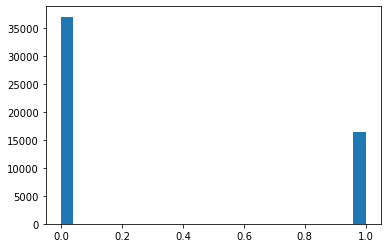

 | is numeric | 2 unique values  | consider one-hot? (ordinal?) 
target percentages:  Normal      69.2
Exploits    20.8
DoS          7.6
Analysis     1.3
Backdoor     1.1
Name: attack_cat, dtype: float64
                  label
label attack_cat       
0     Normal      100.0
1     Analysis      4.1
      Backdoor      3.5
      DoS          24.8
      Exploits     67.5


In [18]:
eda_utils.describe_features(df_test,'attack_cat', True, False)

Name: attack_cat, dtype: int64
* Normal      69.2
* Exploits    20.8
* DoS          7.6
* Analysis     1.3
* Backdoor     1.1

Simple plt.plot, looking for horizontal lines for repeated values or vertical lines for non shuffled
Train id


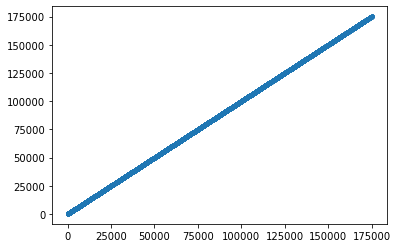

Test id


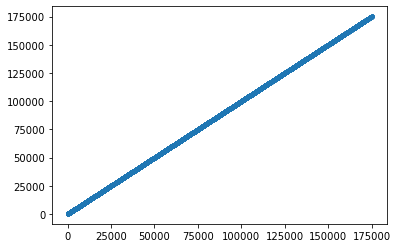

Train dur


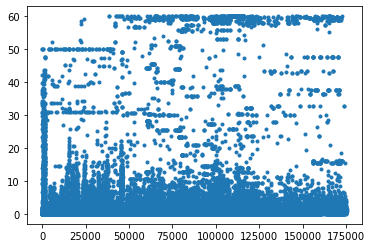

Test dur


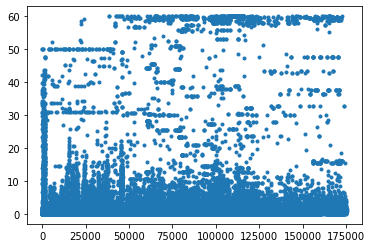

Train spkts


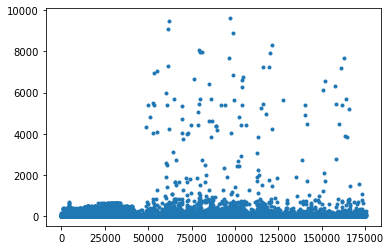

Test spkts


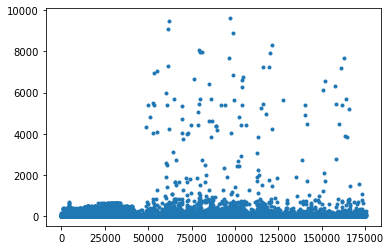

Train dpkts


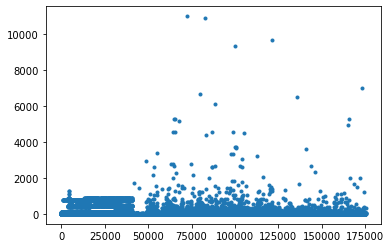

Test dpkts


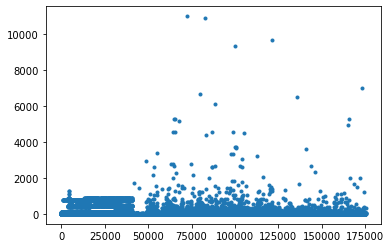

Train sbytes


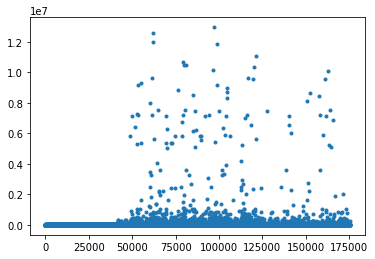

Test sbytes


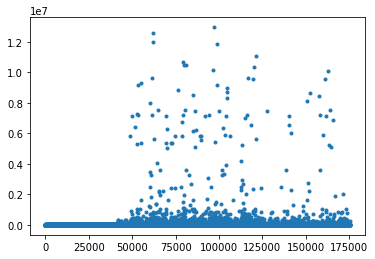

Train dbytes


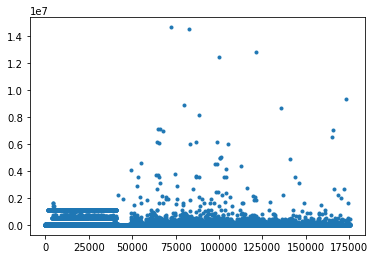

Test dbytes


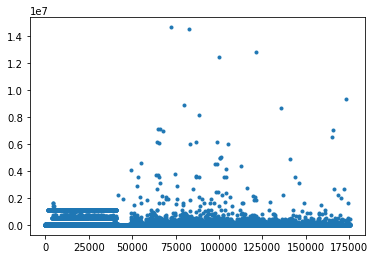

Train rate


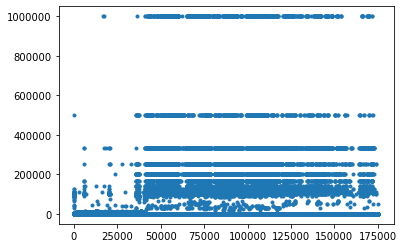

Test rate


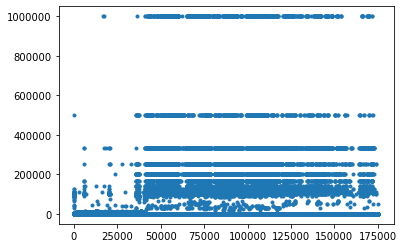

Train sttl


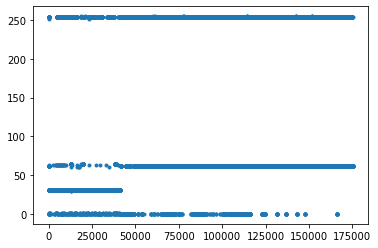

Test sttl


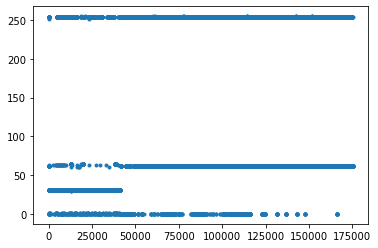

Train dttl


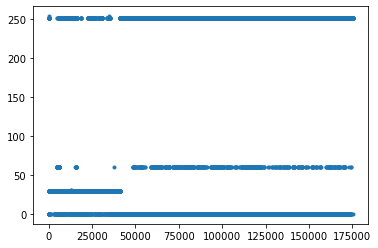

Test dttl


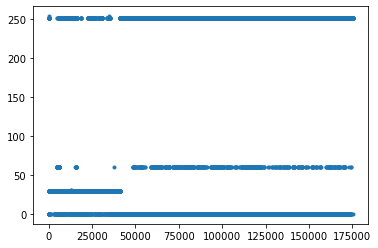

Train sload


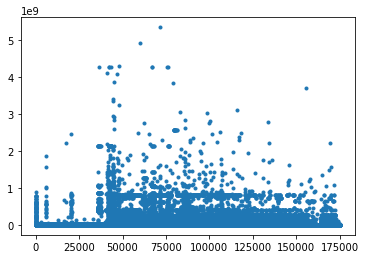

Test sload


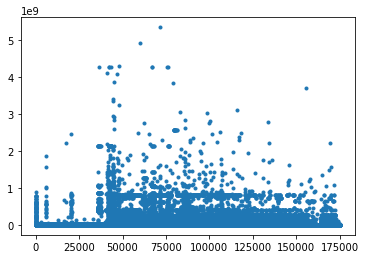

Train dload


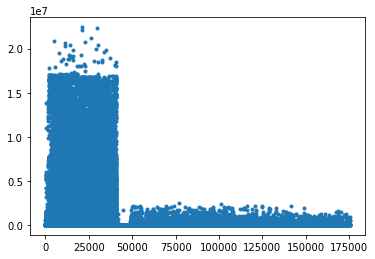

Test dload


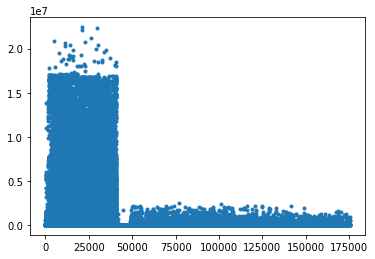

Train sloss


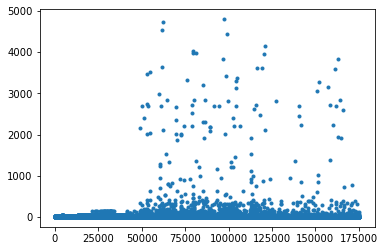

Test sloss


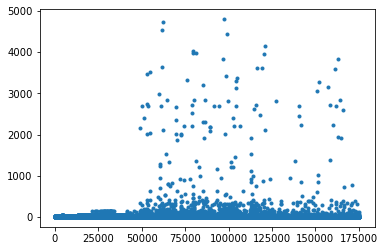

Train dloss


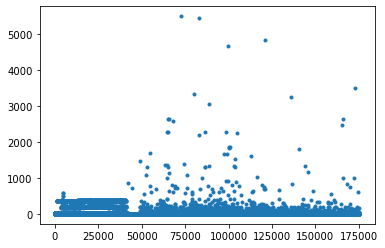

Test dloss


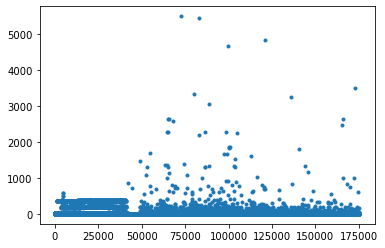

Train sinpkt


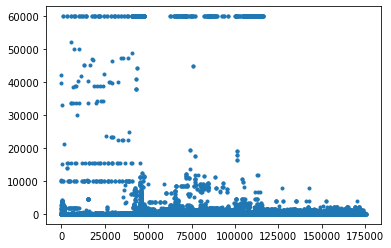

Test sinpkt


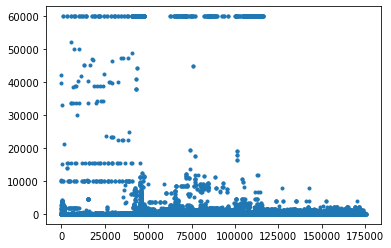

Train dinpkt


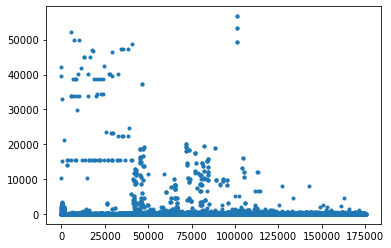

Test dinpkt


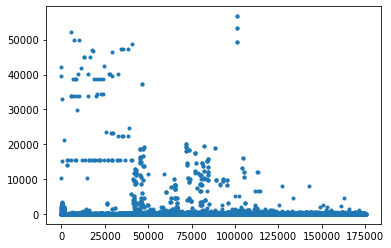

Train sjit


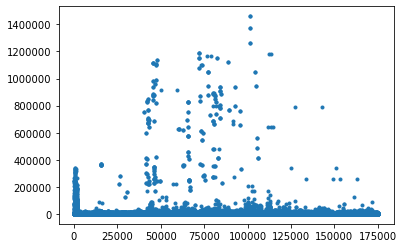

Test sjit


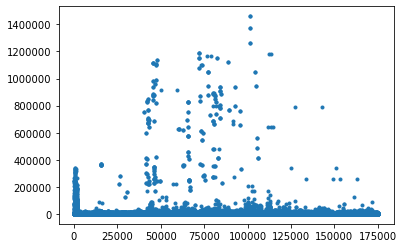

Train djit


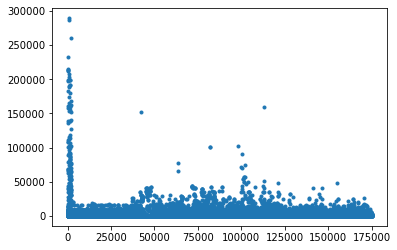

Test djit


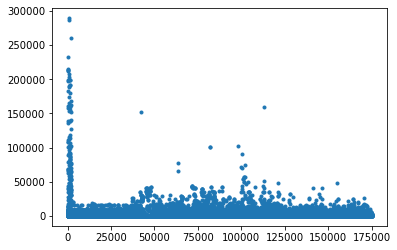

Train swin


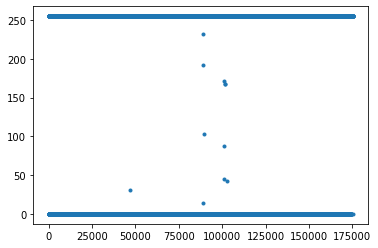

Test swin


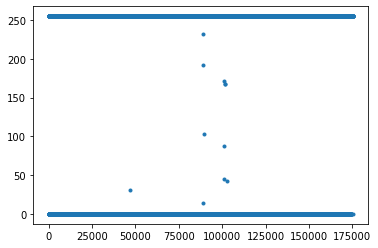

Train stcpb


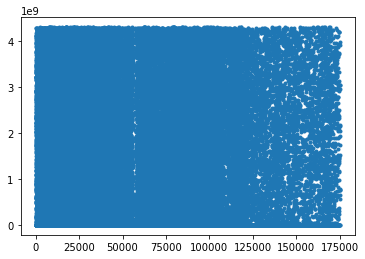

Test stcpb


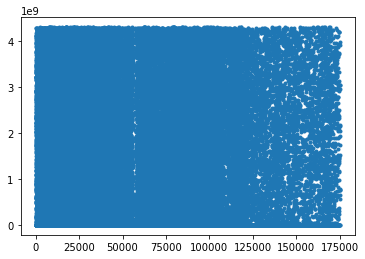

Train dtcpb


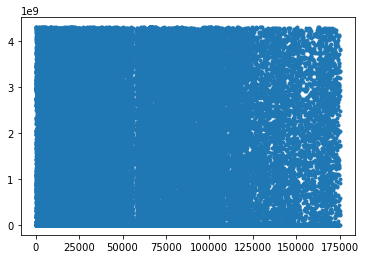

Test dtcpb


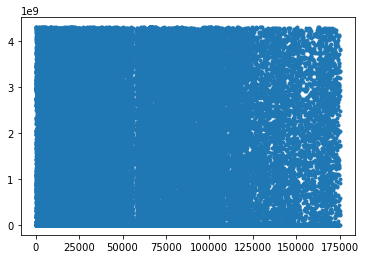

Train dwin


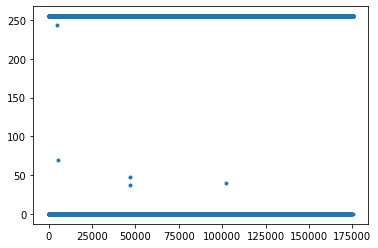

Test dwin


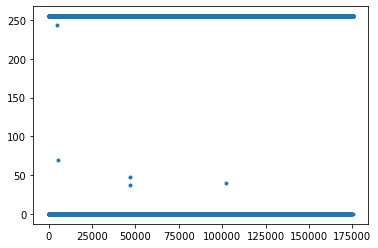

Train tcprtt


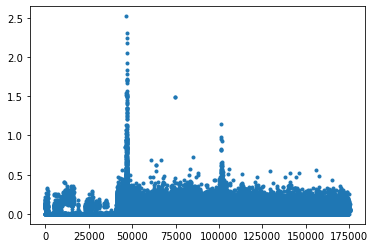

Test tcprtt


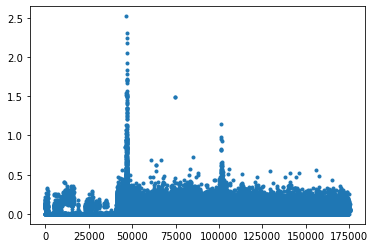

Train synack


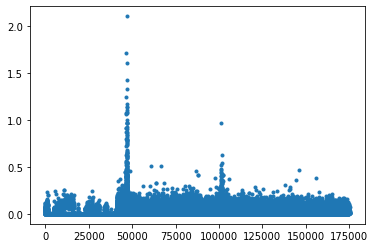

Test synack


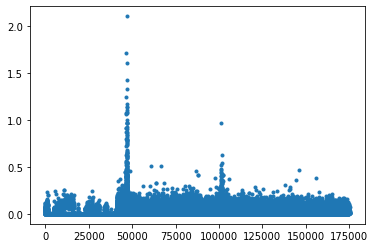

Train ackdat


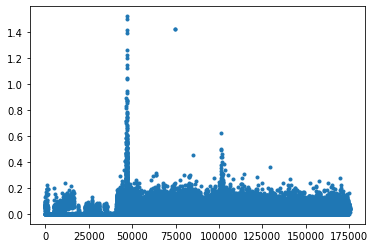

Test ackdat


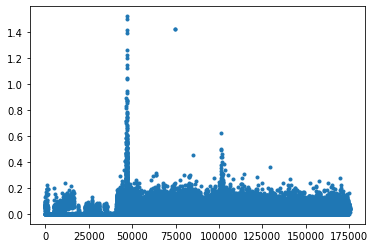

Train smean


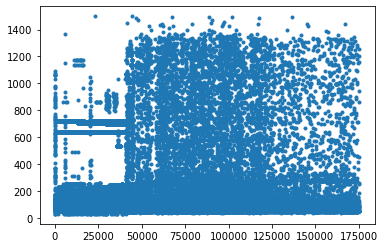

Test smean


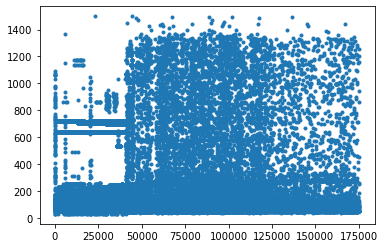

Train dmean


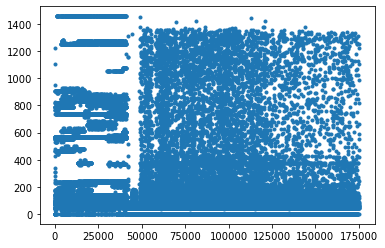

Test dmean


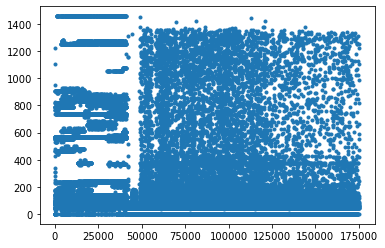

Train trans_depth


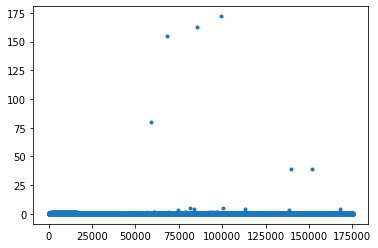

Test trans_depth


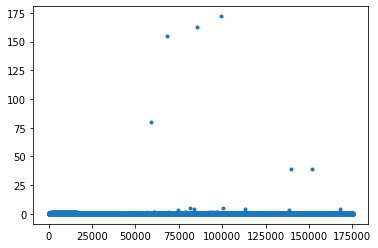

Train response_body_len


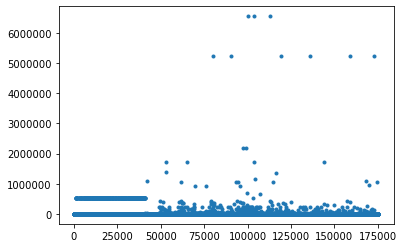

Test response_body_len


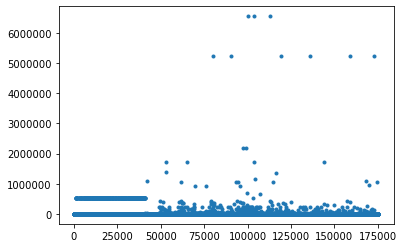

Train ct_srv_src


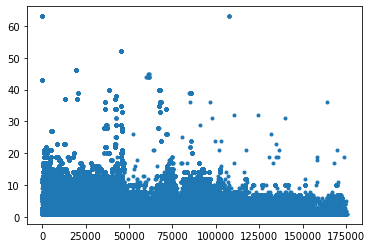

Test ct_srv_src


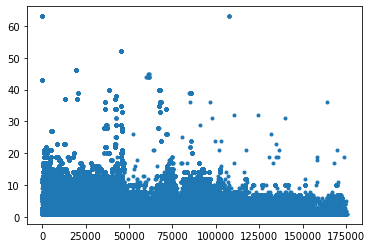

Train ct_state_ttl


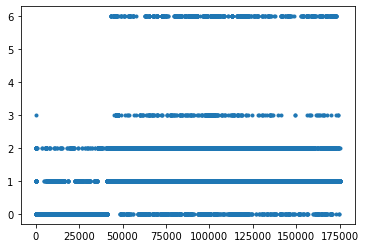

Test ct_state_ttl


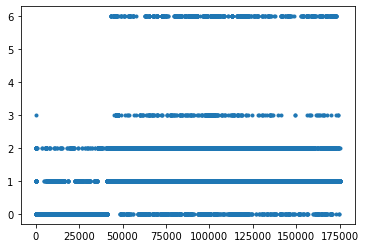

Train ct_dst_ltm


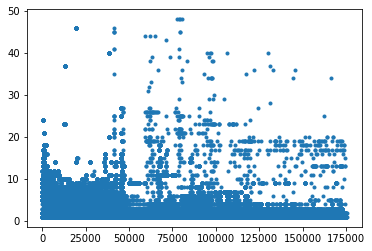

Test ct_dst_ltm


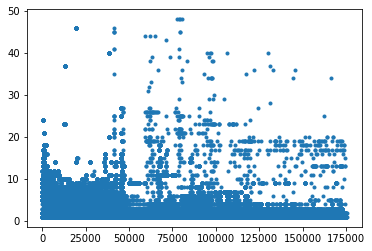

Train ct_src_dport_ltm


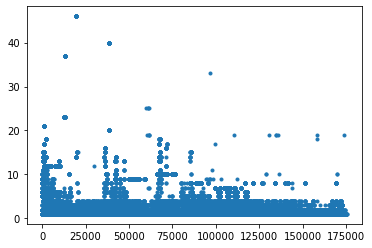

Test ct_src_dport_ltm


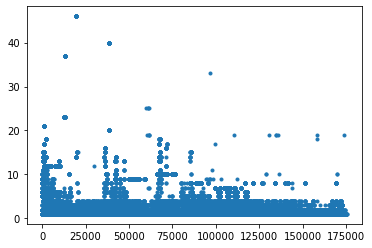

Train ct_dst_sport_ltm


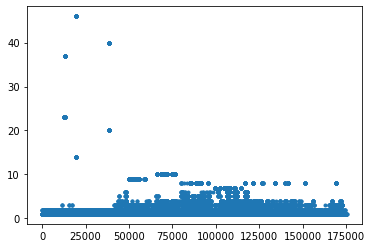

Test ct_dst_sport_ltm


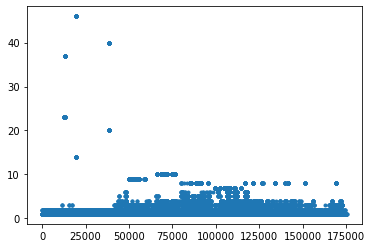

Train ct_dst_src_ltm


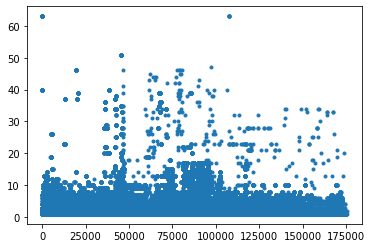

Test ct_dst_src_ltm


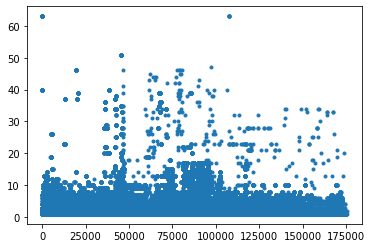

Train is_ftp_login


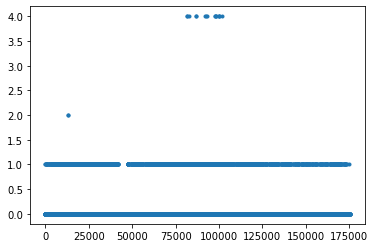

Test is_ftp_login


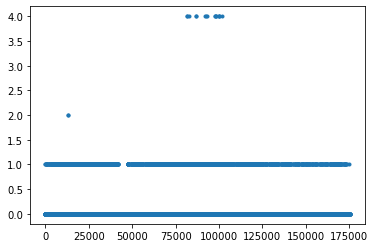

Train ct_ftp_cmd


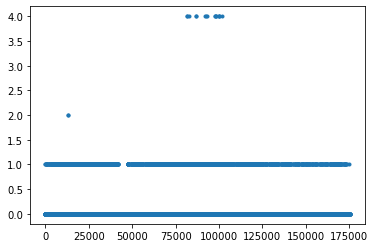

Test ct_ftp_cmd


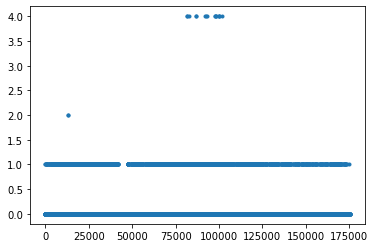

Train ct_flw_http_mthd


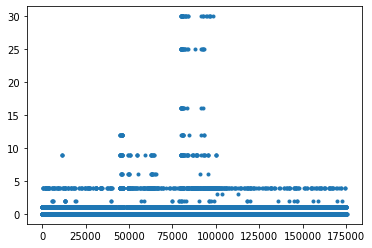

Test ct_flw_http_mthd


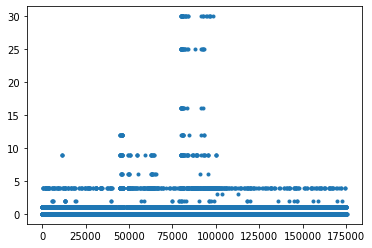

Train ct_src_ltm


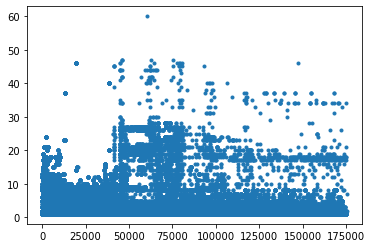

Test ct_src_ltm


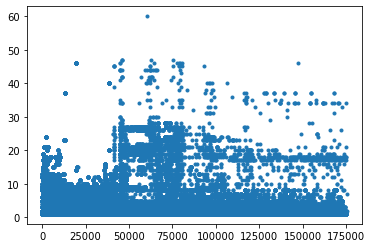

Train ct_srv_dst


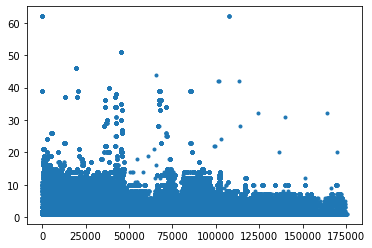

Test ct_srv_dst


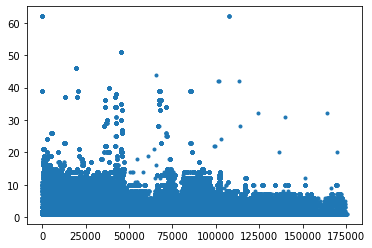

Train is_sm_ips_ports


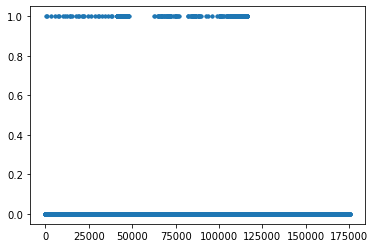

Test is_sm_ips_ports


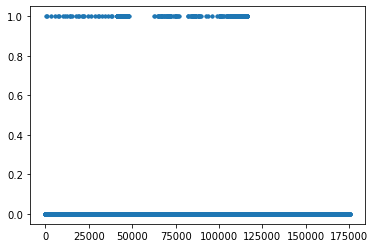

Train label


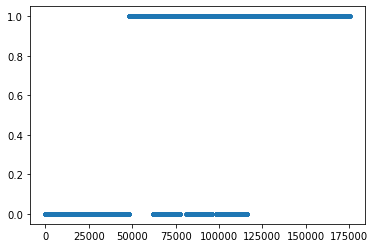

Test label


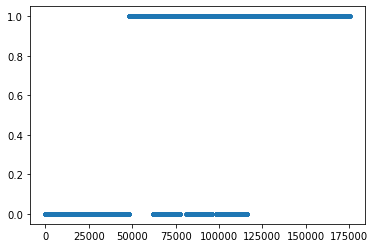

In [27]:
# def index_plots(df_train,df_test=None):
#     print('Simple plt.plot, looking for horizontal lines for repeated values or vertical lines for non shuffled')

eda_utils.index_plots(df_train, df_test)


In [28]:
#def scatter_plot(df_train, df_test=None, target_var_column=None, is_target_categorical=False, jitter=False):
#eda_utils.scatter_plot(df_train,df_test,'label', True)

Columns with least unique values: 
label               2
is_sm_ips_ports     2
is_ftp_login        4
ct_ftp_cmd          4
ct_state_ttl        5
attack_cat          5
dttl                6
dwin                7
state               9
trans_depth        11
dtype: int64
Histogram of unique values


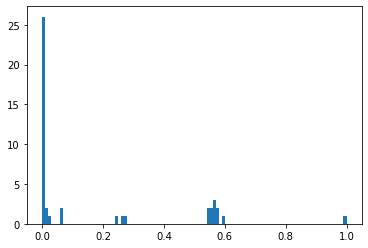

In [29]:
# #check columns without unique values, consider dropping
# def check_column_counts(df):
eda_utils.check_column_counts(df_train)

### Notes:
* All columns ahve unique values

In [30]:
#next time use one in eda_utils, bug is fixed now
def check_unique_train_test_set(df_train,df_test):
    for i in df_train.columns:
        if i in df_test.columns:
            #n_unique_train = df_train[i].nunique(drop_na=False)
            n_unique_train, n_unique_train_count = np.unique(df_train[i],return_counts=True)
            if len(n_unique_train) > 30 and np.issubdtype(df_train[i].dtype, np.number):
                continue
            n_unique_test, n_unique_test_count = np.unique(df_test[i],return_counts=True)
            if len(n_unique_train) != len(n_unique_test):
                print("{}: Feature has different train and test values -- {} vs. {} ".format(i,len(n_unique_train), len(n_unique_test)))
                print(pd.DataFrame({'train__features': n_unique_train, 'train_count': n_unique_train_count}))
                print(pd.DataFrame({'test__features': n_unique_test, 'test_count': n_unique_test_count}))

In [31]:
# #check for values that are only in train set/not in test set and vice versa
# #only doing for categorical columns and numeric columns with 30 or fewer unique values
# #for numeric with wide spread, see plots
# def check_unique_train_test_set(df_train,df_test):
#eda_utils.check_unique_train_test_set(df_train,df_test)

In [32]:
check_unique_train_test_set(df_train,df_test)
                

proto: Feature has different train and test values -- 133 vs. 131 
    train__features  train_count
0               3pc           88
1               a/n           88
2         aes-sp3-d           88
3               any          264
4             argus           87
..              ...          ...
128             wsn           88
129            xnet           87
130         xns-idp           87
131             xtp           88
132            zero           88

[133 rows x 2 columns]
    test__features  test_count
0              3pc          26
1              a/n          26
2        aes-sp3-d          26
3              any          78
4            argus          27
..             ...         ...
126            wsn          26
127           xnet          27
128        xns-idp          27
129            xtp          26
130           zero          26

[131 rows x 2 columns]
state: Feature has different train and test values -- 9 vs. 6 
  train__features  train_count
0             CON      

### to do/notes:
* proto, state, have train values that aren't test values. Need to remove those values as test does not have those values
* for other continuous variables consider if it makes sense to leave continuous, group, etc

In [33]:
#def check_unique_rows(df_train, target_col=None):
eda_utils.check_unique_rows(df_train, target_col='label')

Total Unique Values (Total rows 105403)
id                   105403
dur                   57405
proto                   133
service                  13
state                     9
spkts                   472
dpkts                   431
sbytes                 6675
dbytes                 6469
rate                  59994
sttl                     11
dttl                      6
sload                 62520
dload                 60664
sloss                   398
dloss                   358
sinpkt                59196
dinpkt                57491
sjit                  60392
djit                  59931
swin                     13
stcpb                 58335
dtcpb                 58235
dwin                      7
tcprtt                29287
synack                27729
ackdat                26166
smean                  1321
dmean                  1320
trans_depth              11
response_body_len      2300
ct_srv_src               45
ct_state_ttl              5
ct_dst_ltm               46
ct_src_d

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label


### Notes:
* No dulicated rows, no need to drop any rows for that reason